# Predcition of Hospital Admission Related to Sinusitis

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sinusitis.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'sinusitis_date_'+str(i), 'sinusitis_ab_date_'+str(i), 'sinusitis_ab_type_'+str(i),
                   'incdt_sinusitis_date_'+str(i), 'admitted_sinusitis_date_'+str(i), 'sgss_gp_cov_sinusitis_date_'+str(i)]]
    
    #drop rows with no sinusitis reord
    datum = datum[datum['sinusitis_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with sinusitis_i
    datum = datum[datum['sgss_gp_cov_sinusitis_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'sinusitis_date_'+str(i): 'sinusitis_date', 'sinusitis_ab_date_'+str(i): 'sinusitis_ab_date', 
                           'sinusitis_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_sinusitis_date_'+str(i): 'incdt_sinusitis_date', 'incdt_sinusitis_type_'+str(i): 'incdt_sinusitis_type',
                           'admitted_sinusitis_date_'+str(i): 'admitted_sinusitis_date',
                           'sgss_gp_cov_sinusitis_date_'+str(i): 'sgss_gp_cov_sinusitis_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [18]:
#build cox models stratified with antibiotics history categories
def cox_model_strat_ab_hist_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + sinusitis_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [19]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_sinusitis.csv.gz')

In [20]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [21]:
#process 20 sinusitiss and concatenate them 
data_sinusitis_1 = proc_infec_data(data,1)
data_sinusitis_2 = proc_infec_data(data,2)
data_sinusitis_3 = proc_infec_data(data,3)
data_sinusitis_4 = proc_infec_data(data,4)
data_sinusitis_5 = proc_infec_data(data,5)
data_sinusitis_6 = proc_infec_data(data,6)
data_sinusitis_7 = proc_infec_data(data,7)
data_sinusitis_8 = proc_infec_data(data,8)
data_sinusitis_9 = proc_infec_data(data,9)
data_sinusitis_10 = proc_infec_data(data,10)
data_sinusitis_11 = proc_infec_data(data,11)
data_sinusitis_12 = proc_infec_data(data,12)
data_sinusitis_13 = proc_infec_data(data,13)
data_sinusitis_14 = proc_infec_data(data,14)
data_sinusitis_15 = proc_infec_data(data,15)
data_sinusitis_16 = proc_infec_data(data,16)
data_sinusitis_17 = proc_infec_data(data,17)
data_sinusitis_18 = proc_infec_data(data,18)
data_sinusitis_19 = proc_infec_data(data,19)
data_sinusitis_20 = proc_infec_data(data,20)

data_sinusitis = pd.concat([data_sinusitis_1, data_sinusitis_2, data_sinusitis_3, data_sinusitis_4, data_sinusitis_5, data_sinusitis_6, data_sinusitis_7, data_sinusitis_8, data_sinusitis_9, data_sinusitis_10, data_sinusitis_11, data_sinusitis_12, data_sinusitis_13, data_sinusitis_14, data_sinusitis_15, data_sinusitis_16, data_sinusitis_17, data_sinusitis_18, data_sinusitis_19, data_sinusitis_20])
data_sinusitis.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [22]:
##add variable season
#convert data types
data_sinusitis['sinusitis_date'] = data_sinusitis['sinusitis_date'].astype('datetime64[ns]')
data_sinusitis['admitted_sinusitis_date'] = data_sinusitis['admitted_sinusitis_date'].astype('datetime64[ns]')
data_sinusitis.died_date = data_sinusitis.died_date.astype('datetime64[ns]')
data_sinusitis.deregistered_date = data_sinusitis.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_sinusitis['date'] = data_sinusitis['sinusitis_date'] 
data_sinusitis['date'] = data_sinusitis['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_sinusitis with today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_1_month_date_y_m]
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of sinusitis records
data_sinusitis['season'] = np.nan
data_sinusitis['date_month'] = pd.DatetimeIndex(data_sinusitis['date']).month

conditions = [
    (data_sinusitis['date_month'] >= 3) & (data_sinusitis['date_month'] <= 5),
    (data_sinusitis['date_month'] >= 6) & (data_sinusitis['date_month'] <= 8),
    (data_sinusitis['date_month'] >= 9) & (data_sinusitis['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_sinusitis['season'] = np.select(conditions, choices, default='winter')

In [23]:
#add variable time period
data_sinusitis.loc[(data_sinusitis['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_sinusitis.loc[((data_sinusitis['date'] >= '2020-01') & (data_sinusitis['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_sinusitis.loc[(data_sinusitis['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [24]:
#scenario 1
#not hosped (nothing happened)
data_sinusitis.loc[data_sinusitis['admitted_sinusitis_date'].isnull(), 'event_sinusitis_admitted'] = 0

In [25]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] >= 0) & (data_sinusitis['delta_sinusitis_admitted'] <= 30)), 'event_sinusitis_admitted'] = 1

#scenario 2
#drop whoever was admitted before sinusitis consultation, i.e. negative value for delta_sinusitis_admitted
data_sinusitis = data_sinusitis[~(data_sinusitis['delta_sinusitis_admitted'] < 0)]

In [26]:
#scenario 3
#censor died patients
data_sinusitis['delta_admitted_died'] = (data_sinusitis['died_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_died'] >= 0) & (data_sinusitis['delta_admitted_died'] <= 30)), 'event_sinusitis_admitted'] = 0

#scenario 3
#censor deregistered patients
data_sinusitis['delta_admitted_deregistered'] = (data_sinusitis['deregistered_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_sinusitis.loc[((data_sinusitis['delta_admitted_deregistered'] > 0) & (data_sinusitis['delta_admitted_deregistered'] <= 30)), 'event_sinusitis_admitted'] = 0

#agg scenario 3s
data_sinusitis['delta_admitted_died_deregistered'] = data_sinusitis['delta_admitted_deregistered'].combine_first(data_sinusitis['delta_admitted_died'])
data_sinusitis.loc[data_sinusitis['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [27]:
#scenario 1
#any other patients (nothing happened)
data_sinusitis['event_sinusitis_admitted'] = data_sinusitis['event_sinusitis_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['delta_sinusitis_admitted'].combine_first(data_sinusitis['delta_admitted_died_deregistered'])
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['duration_sinusitis_admitted'].replace(np.NaN, 30)
data_sinusitis.loc[(data_sinusitis['duration_sinusitis_admitted'] > 30), 'duration_sinusitis_admitted'] = 30

#give value 1 to event_sinusitis_admitted if duration_sinusitis_admitted is greater or equal to 0 and less than 30
data_sinusitis.loc[((data_sinusitis['duration_sinusitis_admitted'] >= 0) & (data_sinusitis['duration_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

#drop any rows with value 0 in duration column
data_sinusitis = data_sinusitis[~(data_sinusitis['duration_sinusitis_admitted'] == 0)]

In [28]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] > 0) & (data_sinusitis['delta_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [29]:
#drop anybody with age less than 18 or 0!
data_sinusitis = data_sinusitis[~(data_sinusitis['age'] < 18)] 
data_sinusitis['age'][data_sinusitis['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '0-4']
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_sinusitis['bmi'][data_sinusitis['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_sinusitis['bmi'] = data_sinusitis['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_sinusitis['antibacterial_brit'][data_sinusitis['antibacterial_brit'] < 0] = np.nan

In [30]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"smoking_status": dict_smoking})

In [31]:
#drop rows with missing region
if ('region' in data_sinusitis.columns) and (data_sinusitis['region'].isnull().sum() > 0):
   data_sinusitis = data_sinusitis[data_sinusitis['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_sinusitis.columns) and (data_sinusitis['antibacterial_brit'].isnull().sum() > 0):
    data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_sinusitis.columns) and (data_sinusitis['ethnicity'].isnull().sum() > 0):
    data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_sinusitis.columns) and (data_sinusitis['smoking_status'].isnull().sum() > 0):
    data_sinusitis['smoking_status'] = data_sinusitis['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_sinusitis.columns) and (data_sinusitis['imd'].isnull().sum() > 0):
    data_sinusitis['imd'] = data_sinusitis['imd'].fillna(0)

In [32]:
#missing values of bmi assign 5 and 0; categorise bmi
data_sinusitis['bmi_cat'] = 5

for idx, x in enumerate(data_sinusitis['bmi_cat']):
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 30:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 25) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 30):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] >= 18.5) and (data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 25):
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi')] < 18.5:
        data_sinusitis.iat[idx, data_sinusitis.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_sinusitis.columns) and (data_sinusitis['bmi_cat'].isnull().sum() > 0):
    data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].fillna(0)

In [33]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_sinusitis.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_sinusitis['ab_type_cat'] = np.where(data_sinusitis['ab_type'].isin(ab_series[mask].index),'other',data_sinusitis['ab_type'])
#assign no to non ab users
data_sinusitis.loc[data_sinusitis['sinusitis_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_sinusitis['ab_type_cat'] = data_sinusitis['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [34]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"ethnicity": dict_ethnicity})
data_sinusitis = data_sinusitis.replace({"smoking_status": dict_smoking})
data_sinusitis = data_sinusitis.replace({"imd": dict_imd})
data_sinusitis = data_sinusitis.replace({"bmi_cat": dict_bmi})
data_sinusitis = data_sinusitis.replace({"flu_vaccine": dict_flu})
data_sinusitis = data_sinusitis.replace({"region": dict_region})
data_sinusitis = data_sinusitis.replace({"age_cat": dict_age})
data_sinusitis = data_sinusitis.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [35]:
#categorise CCI
data_sinusitis['CCI_cat'] = pd.cut(data_sinusitis['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_sinusitis['antibacterial_brit'].clip(0, data_sinusitis['antibacterial_brit'].quantile(0.95), inplace=True)
#categorise antibiotic hisotry
data_sinusitis['antibacterial_brit_cat'] = pd.cut(data_sinusitis['antibacterial_brit'], right=False, bins=[0,1,2,5,10000], labels=['none0', 'low1', 'medium2_4', 'high5_more'])
data_sinusitis['antibacterial_brit_cat'].value_counts()

none0         91484
medium2_4     74858
low1          11939
high5_more        0
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

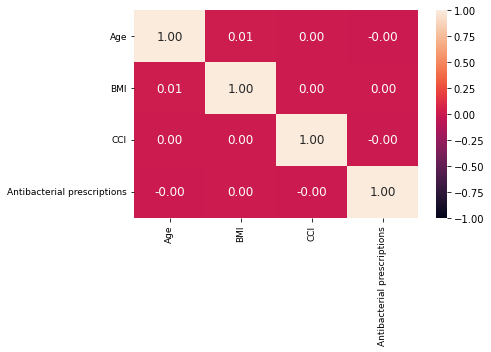

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_sinusitis[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/corr_sinusitis.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [37]:
data_sinusitis = data_sinusitis[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'antibacterial_brit_cat', 'sinusitis_ab_date', 'ab_type_cat', 'incdt_sinusitis_date', 'date', 'period',
                                   'event_sinusitis_admitted', 'duration_sinusitis_admitted'
                                    ]]

In [38]:
#incident and prevalent infection 
data_sinusitis_incdt = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 0]
data_sinusitis_prevl = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 1]
#switch variable sinusitis_ab_date into a binary variable
data_sinusitis_incdt[['sinusitis_ab_date']] = data_sinusitis_incdt[['sinusitis_ab_date']].where(data_sinusitis_incdt[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)
data_sinusitis_prevl[['sinusitis_ab_date']] = data_sinusitis_prevl[['sinusitis_ab_date']].where(data_sinusitis_prevl[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_sinusitis_incdt_males = data_sinusitis_incdt[data_sinusitis_incdt['sex'] == 'male']
data_sinusitis_incdt_females = data_sinusitis_incdt[data_sinusitis_incdt['sex'] == 'female']
data_sinusitis_prevl_males = data_sinusitis_prevl[data_sinusitis_prevl['sex'] == 'male']
data_sinusitis_prevl_females = data_sinusitis_prevl[data_sinusitis_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_sinusitis_incdt_15_24 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '15_24']
data_sinusitis_incdt_25_34 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '25_34']
data_sinusitis_incdt_35_44 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '35_44']
data_sinusitis_incdt_45_54 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '45_54']
data_sinusitis_incdt_55_64 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '55_64']
data_sinusitis_incdt_65_74 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '65_74']
data_sinusitis_incdt_75_more = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '75_more']
data_sinusitis_prevl_15_24 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '15_24']
data_sinusitis_prevl_25_34 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '25_34']
data_sinusitis_prevl_35_44 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '35_44']
data_sinusitis_prevl_45_54 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '45_54']
data_sinusitis_prevl_55_64 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '55_64']
data_sinusitis_prevl_65_74 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '65_74']
data_sinusitis_prevl_75_more = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_sinusitis_incdt_prepandemic = data_sinusitis_incdt[data_sinusitis_incdt['date'] <= '2019-12']
data_sinusitis_incdt_during_pandemic = data_sinusitis_incdt[(data_sinusitis_incdt['date'] >= '2020-03') & (data_sinusitis_incdt['date']<= '2021-03')]
data_sinusitis_incdt_post_2nd_lockdown = data_sinusitis_incdt[data_sinusitis_incdt['date'] <= '2021-04']
data_sinusitis_prevl_prepandemic = data_sinusitis_prevl[data_sinusitis_prevl['date'] <= '2019-12']
data_sinusitis_prevl_during_pandemic = data_sinusitis_prevl[(data_sinusitis_prevl['date'] >= '2020-03') & (data_sinusitis_prevl['date']<= '2021-03')]
data_sinusitis_prevl_post_2nd_lockdown = data_sinusitis_prevl[data_sinusitis_prevl['date'] <= '2021-04']

#incident and prevalent infection stratified by antibiotics history categories
data_sinusitis_incdt_none0 = data_sinusitis_incdt[data_sinusitis_incdt['antibacterial_brit_cat'] == 'none0']
data_sinusitis_incdt_low1 = data_sinusitis_incdt[data_sinusitis_incdt['antibacterial_brit_cat'] == 'low1']
data_sinusitis_incdt_medium2_4 = data_sinusitis_incdt[data_sinusitis_incdt['antibacterial_brit_cat'] == 'medium2_4']
data_sinusitis_incdt_high5_more = data_sinusitis_incdt[data_sinusitis_incdt['antibacterial_brit_cat'] == 'high5_more']
data_sinusitis_prevl_none0 = data_sinusitis_prevl[data_sinusitis_prevl['antibacterial_brit_cat'] == 'none0']
data_sinusitis_prevl_low1 = data_sinusitis_prevl[data_sinusitis_prevl['antibacterial_brit_cat'] == 'low1']
data_sinusitis_prevl_medium2_4 = data_sinusitis_prevl[data_sinusitis_prevl['antibacterial_brit_cat'] == 'medium2_4']
data_sinusitis_prevl_high5_more = data_sinusitis_prevl[data_sinusitis_prevl['antibacterial_brit_cat'] == 'high5_more']

# no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt = data_sinusitis[data_sinusitis['sinusitis_ab_date'].isnull()]
data_sinusitis_no_abs_incdt = data_sinusitis_no_abs_incdt[data_sinusitis_no_abs_incdt['incdt_sinusitis_date'] == 0]

# with antibiotics and incident hospital admission
data_sinusitis_abs_incdt = data_sinusitis[data_sinusitis['sinusitis_ab_date'].notnull()]
data_sinusitis_abs_incdt = data_sinusitis_abs_incdt[data_sinusitis_abs_incdt['incdt_sinusitis_date'] == 0]

# no antibiotics and prevalent hospital admission
data_sinusitis_no_abs_prevl = data_sinusitis[data_sinusitis['sinusitis_ab_date'].isnull()]
data_sinusitis_no_abs_prevl = data_sinusitis_no_abs_prevl[data_sinusitis_no_abs_prevl['incdt_sinusitis_date'] == 1]

# with antibiotics and prevalent hospital admission
data_sinusitis_abs_prevl = data_sinusitis[data_sinusitis['sinusitis_ab_date'].notnull()]
data_sinusitis_abs_prevl = data_sinusitis_abs_prevl[data_sinusitis_abs_prevl['incdt_sinusitis_date'] == 1]

In [39]:
#store data for plotting hosp admission counts and percentages
%store data_sinusitis
# save data
data_sinusitis.to_csv('../output/hospitalisation_prediction_sinusitis/data_sinusitis.csv')

Stored 'data_sinusitis' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident sinusitis with no antibiotics

<lifelines.CoxPHFitter: fitted with 108417 total observations, 107703 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 108417
number of events observed = 714
   partial log-likelihood = -8255.10
         time fit was run = 2023-06-21 13:44:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.15       1.16       0.11            -0.08             0.37                 0.93                 1.45
CCI_cat[T.medium]                0.15       1.16       0.13            -0.10             0.39                 0.90                 1.48
CCI_cat[T.high]                  0.12       1.13       0.15            -0.18             0.41                 0.84                 1.51
CCI_cat[T.very_high]             0.08       1.09       0.13            -0.18             0.35                 0.84                 1.41
age_cat[T.25_34]                 0.05       1.05       0.14            -0.23             0.33                 0.80                 1.39
age_cat[T.35_44]                -0.06       0.94       0.14            -0.34             0.22                 0.71                 1.25
age_cat[T.45_54]                 0.11       1.11       0.14            -0.16             0.38                 0.85                 1.46
age_cat[T.55_64]                -0.05       0.95       0.14            -0.34             0.23                 0.71                 1.26
age_cat[T.65_74]                 0.05       1.05       0.14            -0.23             0.33                 0.80                 1.39
age_cat[T.75_more]               0.12       1.12       0.14            -0.16             0.39                 0.86                 1.48
antibacterial_brit               0.04       1.04       0.03            -0.01             0.09                 0.99                 1.09
bmi_cat[T.obese]                 0.01       1.01       0.14            -0.26             0.28                 0.77                 1.32
bmi_cat[T.overweight]           -0.08       0.92       0.17            -0.42             0.25                 0.66                 1.29
bmi_cat[T.underweight]          -0.40       0.67       0.28            -0.95             0.16                 0.39                 1.17
bmi_cat[T.unknown]              -0.06       0.95       0.15            -0.35             0.24                 0.71                 1.27
ethnicity[T.unknown]             0.19       1.20       0.12            -0.05             0.42                 0.95                 1.53
ethnicity[T.white]               0.00       1.00       0.11            -0.21             0.22                 0.81                 1.25
flu_vaccine[T.yes]               0.17       1.18       0.12            -0.06             0.40                 0.94                 1.49
imd[T.medium]                   -0.15       0.86       0.12            -0.39             0.08                 0.68                 1.08
imd[T.unaffluent]               -0.15       0.86       0.12            -0.38             0.08                 0.68                 1.08
imd[T.unknown]                  -0.09       0.92       0.18            -0.44             0.27                 0.64                 1.31
imd[T.very_affluent]            -0.10       0.91       0.12            -0.32             0.13                 0.72                 1.14
imd[T.very_unaffluent]          -0.29       0.75       0.12            -0.53            -0.05                 0.59                 0.95
region[T.east_midlands]         -0.12       0.89       0.16            -0.44             0.21                 0.65                 1.23
region[T.london]                -0.14       0.87       

12793


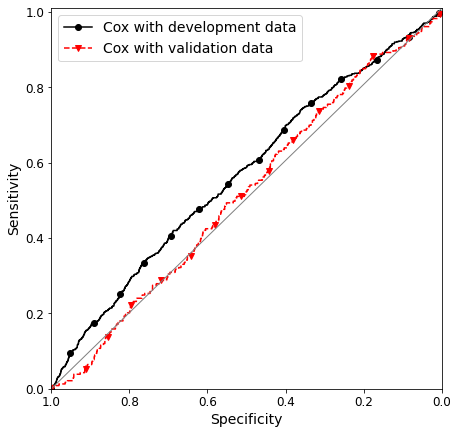

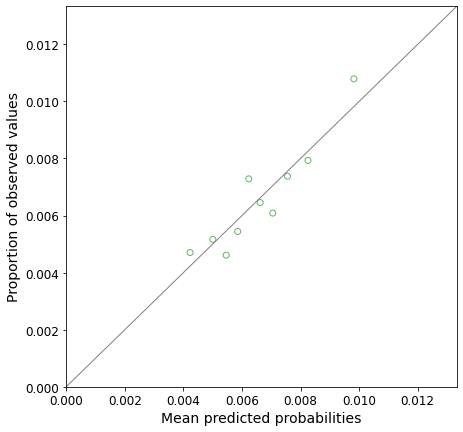

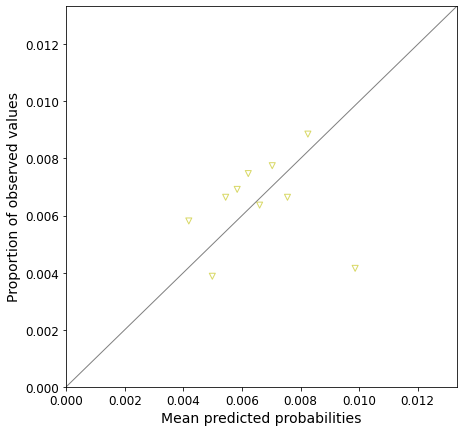

In [40]:
#data prep
data, data_sinusitis_no_abs_incdt_enc = cox_data_prep(data_sinusitis_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)

try:
    #build cox model 
    cph_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test = cox_model_build('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_sinusitis_no_abs_incdt, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_no_abs_incdt.csv', data_sinusitis_no_abs_incdt_enc, data_sinusitis_no_abs_incdt, 'sum_betas_cph_sinusitis_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_sinusitis_no_abs_incdt, 'event_sinusitis_admitted', data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_train, 'event_sinusitis_admitted', data_sinusitis_no_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_no_abs_incdt_train.jpg', 'calibration_cph_sinusitis_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_no_abs_incdt, 'sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident sinusitis with antibiotics

<lifelines.CoxPHFitter: fitted with 11990 total observations, 11907 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 11990
number of events observed = 83
   partial log-likelihood = -761.94
         time fit was run = 2023-06-21 13:44:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.00       1.00       0.30            -0.58             0.59                 0.56                 1.80
CCI_cat[T.medium]               -0.24       0.78       0.35            -0.93             0.44                 0.40                 1.55
CCI_cat[T.high]                 -0.55       0.58       0.48            -1.48             0.38                 0.23                 1.47
CCI_cat[T.very_high]            -0.54       0.58       0.40            -1.32             0.24                 0.27                 1.27
age_cat[T.25_34]                -0.02       0.98       0.41            -0.82             0.78                 0.44                 2.18
age_cat[T.35_44]                -0.56       0.57       0.48            -1.49             0.37                 0.22                 1.45
age_cat[T.45_54]                 0.26       1.30       0.38            -0.49             1.01                 0.61                 2.76
age_cat[T.55_64]                 0.07       1.07       0.40            -0.71             0.86                 0.49                 2.36
age_cat[T.65_74]                -0.16       0.85       0.43            -1.01             0.68                 0.37                 1.96
age_cat[T.75_more]               0.06       1.06       0.40            -0.73             0.84                 0.48                 2.32
antibacterial_brit              -0.03       0.97       0.08            -0.19             0.12                 0.83                 1.13
bmi_cat[T.obese]                 0.12       1.13       0.44            -0.73             0.98                 0.48                 2.66
bmi_cat[T.overweight]           -0.13       0.87       0.56            -1.23             0.96                 0.29                 2.61
bmi_cat[T.underweight]           0.21       1.23       0.71            -1.18             1.59                 0.31                 4.93
bmi_cat[T.unknown]               0.28       1.32       0.46            -0.62             1.17                 0.54                 3.24
ethnicity[T.unknown]            -0.22       0.80       0.32            -0.86             0.41                 0.42                 1.51
ethnicity[T.white]              -0.43       0.65       0.29            -0.99             0.13                 0.37                 1.14
flu_vaccine[T.yes]               0.12       1.13       0.35            -0.57             0.81                 0.56                 2.25
imd[T.medium]                    0.03       1.03       0.38            -0.71             0.77                 0.49                 2.16
imd[T.unaffluent]                0.45       1.57       0.34            -0.22             1.12                 0.80                 3.07
imd[T.unknown]                  -1.40       0.25       1.04            -3.43             0.63                 0.03                 1.88
imd[T.very_affluent]             0.33       1.39       0.35            -0.36             1.02                 0.70                 2.78
imd[T.very_unaffluent]          -0.08       0.92       0.39            -0.84             0.67                 0.43                 1.96
region[T.east_midlands]          0.13       1.14       0.52            -0.89             1.14                 0.41                 3.14
region[T.london]                 0.35       1.41       0.44 

12780


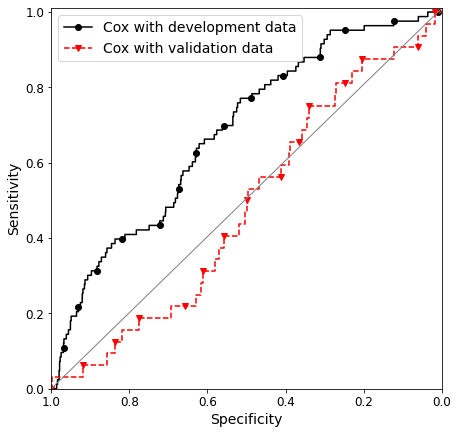

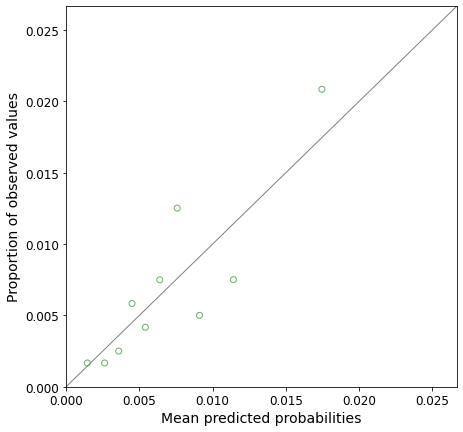

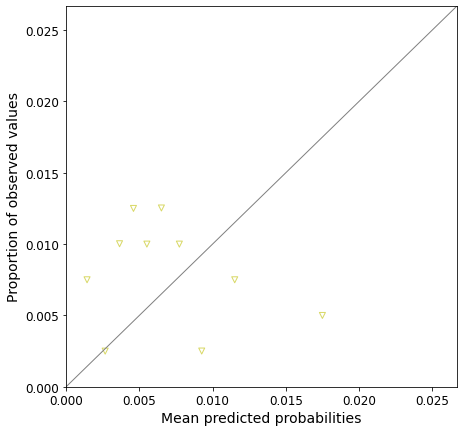

In [41]:
#data prep
data, data_sinusitis_abs_incdt_enc = cox_data_prep(data_sinusitis_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)

try:
    #build cox model 
    cph_sinusitis_abs_incdt, data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test = cox_model_build('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_sinusitis_abs_incdt, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_abs_incdt.csv', data_sinusitis_abs_incdt_enc, data_sinusitis_abs_incdt, 'sum_betas_cph_sinusitis_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_sinusitis_abs_incdt, 'event_sinusitis_admitted', data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_sinusitis_abs_incdt, data_sinusitis_abs_incdt_train, 'event_sinusitis_admitted', data_sinusitis_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_abs_incdt_train.jpg', 'calibration_cph_sinusitis_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_abs_incdt, 'sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent sinusitis with no antibiotics

<lifelines.CoxPHFitter: fitted with 11987 total observations, 11922 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 11987
number of events observed = 65
   partial log-likelihood = -587.10
         time fit was run = 2023-06-21 13:45:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.24       0.79       0.34            -0.91             0.43                 0.40                 1.53
CCI_cat[T.medium]               -0.30       0.74       0.39            -1.05             0.46                 0.35                 1.59
CCI_cat[T.high]                 -0.10       0.91       0.44            -0.97             0.78                 0.38                 2.17
CCI_cat[T.very_high]            -0.69       0.50       0.46            -1.60             0.22                 0.20                 1.24
age_cat[T.25_34]                 1.17       3.21       0.47             0.24             2.09                 1.27                 8.10
age_cat[T.35_44]                -0.03       0.97       0.58            -1.16             1.10                 0.31                 3.02
age_cat[T.45_54]                -0.33       0.72       0.65            -1.60             0.94                 0.20                 2.55
age_cat[T.55_64]                 0.84       2.33       0.49            -0.12             1.81                 0.88                 6.13
age_cat[T.65_74]                 0.36       1.44       0.54            -0.70             1.42                 0.50                 4.15
age_cat[T.75_more]               0.53       1.70       0.52            -0.48             1.54                 0.62                 4.69
antibacterial_brit              -0.10       0.91       0.09            -0.27             0.08                 0.76                 1.08
bmi_cat[T.obese]                -0.13       0.87       0.45            -1.01             0.74                 0.37                 2.09
bmi_cat[T.overweight]           -0.48       0.62       0.61            -1.67             0.71                 0.19                 2.03
bmi_cat[T.underweight]           0.35       1.42       0.71            -1.04             1.74                 0.35                 5.72
bmi_cat[T.unknown]               0.01       1.01       0.47            -0.92             0.94                 0.40                 2.55
ethnicity[T.unknown]            -0.27       0.76       0.38            -1.02             0.48                 0.36                 1.62
ethnicity[T.white]              -0.28       0.75       0.33            -0.94             0.37                 0.39                 1.45
flu_vaccine[T.yes]               0.10       1.10       0.40            -0.69             0.88                 0.50                 2.42
imd[T.medium]                   -0.45       0.64       0.39            -1.21             0.31                 0.30                 1.37
imd[T.unaffluent]               -0.79       0.45       0.43            -1.63             0.05                 0.20                 1.05
imd[T.unknown]                  -0.03       0.97       0.56            -1.12             1.07                 0.33                 2.90
imd[T.very_affluent]            -0.39       0.68       0.38            -1.13             0.35                 0.32                 1.42
imd[T.very_unaffluent]          -0.31       0.74       0.37            -1.03             0.42                 0.36                 1.52
region[T.east_midlands]         -0.25       0.78       0.56            -1.35             0.84                 0.26                 2.31
region[T.london]                 0.00       1.00       0.46 

12820


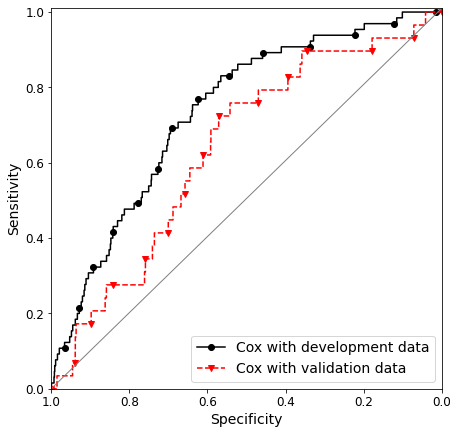

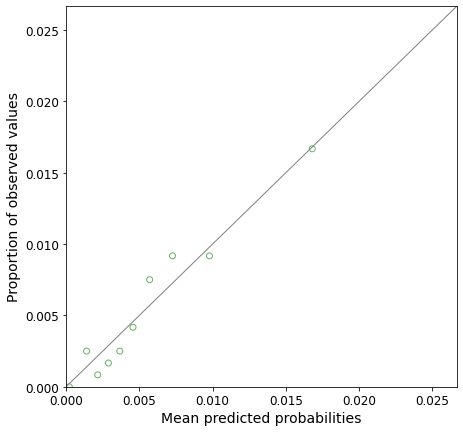

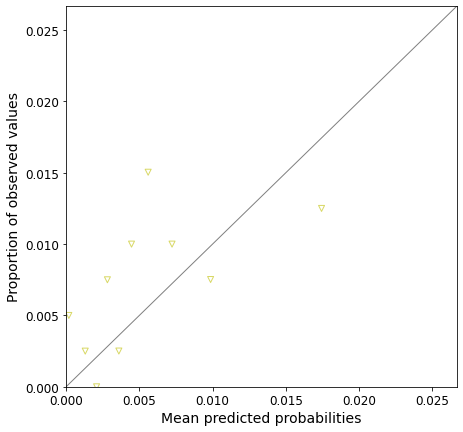

In [42]:
#data prep
data, data_sinusitis_no_abs_prevl_enc = cox_data_prep(data_sinusitis_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)

try:
    #build cox model 
    cph_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test = cox_model_build('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_sinusitis_no_abs_prevl, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_no_abs_prevl.csv', data_sinusitis_no_abs_prevl_enc, data_sinusitis_no_abs_prevl, 'sum_betas_cph_sinusitis_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_sinusitis_no_abs_prevl, 'event_sinusitis_admitted', data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_train, 'event_sinusitis_admitted', data_sinusitis_no_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_no_abs_prevl_train.jpg', 'calibration_cph_sinusitis_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_no_abs_prevl, 'sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent sinusitis with antibiotics

<lifelines.CoxPHFitter: fitted with 1316 total observations, 1306 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1316
number of events observed = 10
   partial log-likelihood = -41.83
         time fit was run = 2023-06-21 13:45:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.47       0.23       0.99            -3.41             0.47                 0.03                 1.61
CCI_cat[T.medium]              -20.63       0.00    8686.38        -17045.63         17004.37                 0.00                  inf
CCI_cat[T.high]                 -0.88       0.42       1.24            -3.31             1.56                 0.04                 4.75
CCI_cat[T.very_high]            -2.85       0.06       1.69            -6.17             0.47                 0.00                 1.61
age_cat[T.25_34]               -17.80       0.00   10890.73        -21363.25         21327.65                 0.00                  inf
age_cat[T.35_44]                -0.24       0.78       1.50            -3.19             2.71                 0.04                14.97
age_cat[T.45_54]                 2.26       9.57       1.54            -0.76             5.28                 0.47               196.43
age_cat[T.55_64]                 1.54       4.68       1.34            -1.09             4.17                 0.34                64.86
age_cat[T.65_74]                 2.24       9.40       1.48            -0.65             5.13                 0.52               169.42
age_cat[T.75_more]               0.07       1.07       1.60            -3.07             3.20                 0.05                24.60
antibacterial_brit              -0.12       0.88       0.31            -0.74             0.49                 0.48                 1.63
bmi_cat[T.obese]                20.33   6.76e+08   13639.24        -26712.10         26752.76                 0.00                  inf
bmi_cat[T.overweight]           20.40   7.26e+08   13639.24        -26712.02         26752.83                 0.00                  inf
bmi_cat[T.underweight]          -2.18       0.11   22169.23        -43453.08         43448.72                 0.00                  inf
bmi_cat[T.unknown]              18.72   1.36e+08   13639.24        -26713.70         26751.15                 0.00                  inf
ethnicity[T.unknown]             1.73       5.65       1.16            -0.54             4.01                 0.58                55.05
ethnicity[T.white]              -2.15       0.12       1.20            -4.51             0.21                 0.01                 1.24
flu_vaccine[T.yes]               2.27       9.71       1.14             0.03             4.51                 1.03                91.15
imd[T.medium]                    3.08      21.83       1.40             0.34             5.83                 1.40               339.10
imd[T.unaffluent]                3.10      22.28       1.39             0.37             5.83                 1.45               341.89
imd[T.unknown]                 -17.50       0.00   21787.45        -42720.11         42685.10                 0.00                  inf
imd[T.very_affluent]             2.33      10.24       1.69            -0.99             5.64                 0.37               282.67
imd[T.very_unaffluent]         -19.17       0.00    8131.13        -15955.90         15917.55                 0.00                  inf
region[T.east_midlands]          1.81       6.11   19124.88        -37482.26         37485.88                 0.00                  inf
region[T.london]                22.31   4.89e+09   11978.42     

13026


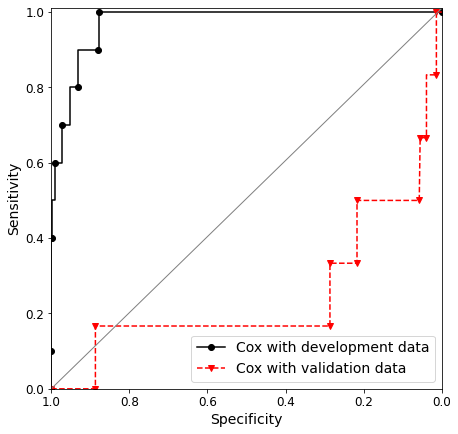

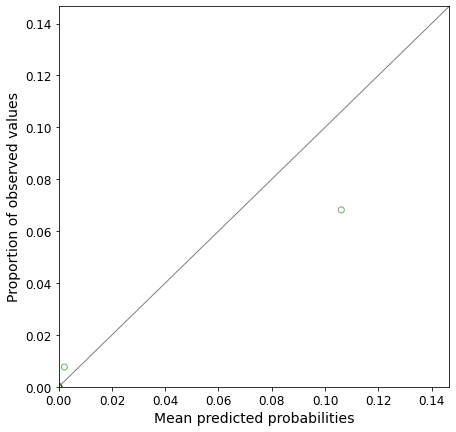

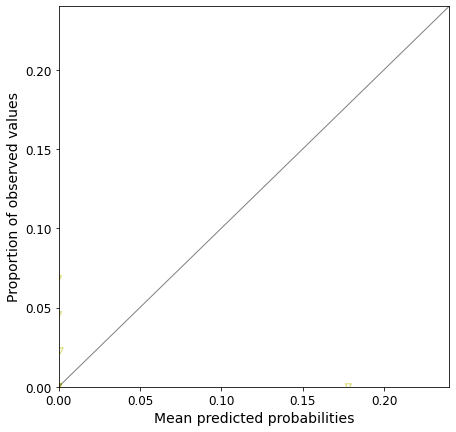

In [43]:
#data prep
data, data_sinusitis_abs_prevl_enc = cox_data_prep(data_sinusitis_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)

try:
    #build cox model 
    cph_sinusitis_abs_prevl, data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test = cox_model_build('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    cox_betas_sumbetas_calculate(cph_sinusitis_abs_prevl, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_abs_prevl.csv', data_sinusitis_abs_prevl_enc, data_sinusitis_abs_prevl, 'sum_betas_cph_sinusitis_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cox_roc_curve(cph_sinusitis_abs_prevl, 'event_sinusitis_admitted', data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cox_calibration(cph_sinusitis_abs_prevl, data_sinusitis_abs_prevl_train, 'event_sinusitis_admitted', data_sinusitis_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_abs_prevl_train.jpg', 'calibration_cph_sinusitis_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_abs_prevl, 'sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident sinusitis

In [44]:
#data prep
data, data_sinusitis_incdt_enc = cox_data_prep(data_sinusitis_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary tables from preped data
make_summary_table('sinusitis', 'incdt', data_sinusitis_incdt_enc)
make_summary_table_hosped('sinusitis', 'incdt', data_sinusitis_incdt)

try:
    cph_sinusitis_incdt, data_sinusitis_incdt_train, data_sinusitis_incdt_test = cox_model_abs_build('sinusitis', 'incdt', data_sinusitis_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt, 'sinusitis', 'incdt', data_sinusitis_incdt_train, data_sinusitis_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120407 total observations, 119601 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 120407
number of events observed = 806
   partial log-likelihood = -9404.78
         time fit was run = 2023-06-21 13:45:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.00       1.00       0.11            -0.20             0.21                 0.82                 1.23
CCI_cat[T.medium]                0.11       1.11       0.11            -0.12             0.33                 0.89                 1.39
CCI_cat[T.high]                 -0.08       0.92       0.14            -0.36             0.20                 0.70                 1.22
CCI_cat[T.very_high]             0.04       1.04       0.12            -0.20             0.28                 0.82                 1.32
age_cat[T.25_34]                 0.18       1.20       0.13            -0.07             0.44                 0.93                 1.56
age_cat[T.35_44]                -0.15       0.86       0.14            -0.43             0.13                 0.65                 1.14
age_cat[T.45_54]                 0.21       1.24       0.13            -0.04             0.47                 0.96                 1.60
age_cat[T.55_64]                 0.05       1.06       0.14            -0.21             0.32                 0.81                 1.38
age_cat[T.65_74]                 0.06       1.06       0.14            -0.21             0.33                 0.81                 1.38
age_cat[T.75_more]               0.14       1.15       0.13            -0.12             0.40                 0.89                 1.50
antibacterial_brit               0.01       1.01       0.02            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                -0.06       0.94       0.13            -0.31             0.19                 0.73                 1.21
bmi_cat[T.overweight]           -0.16       0.85       0.16            -0.48             0.16                 0.62                 1.17
bmi_cat[T.underweight]          -0.44       0.65       0.26            -0.95             0.08                 0.39                 1.08
bmi_cat[T.unknown]              -0.04       0.96       0.14            -0.31             0.23                 0.74                 1.26
ethnicity[T.unknown]             0.05       1.05       0.11            -0.16             0.26                 0.85                 1.30
ethnicity[T.white]              -0.17       0.85       0.10            -0.36             0.03                 0.70                 1.03
flu_vaccine[T.yes]               0.15       1.16       0.11            -0.07             0.37                 0.94                 1.44
imd[T.medium]                   -0.06       0.94       0.11            -0.28             0.16                 0.75                 1.17
imd[T.unaffluent]               -0.07       0.93       0.11            -0.29             0.15                 0.75                 1.16
imd[T.unknown]                  -0.08       0.93       0.17            -0.42             0.27                 0.66                 1.31
imd[T.very_affluent]            -0.01       0.99       0.11            -0.22             0.21                 0.80                 1.23
imd[T.very_unaffluent]          -0.21       0.81       0.12            -0.44             0.02                 0.64                 1.02
region[T.east_midlands]          0.03       1.03       0.16            -0.28             0.33                 0.76                 1.40
region[T.london]                -0.04       0.97       

13067


### 5-6- hospital admission related to prevalent sinusitis

In [45]:
#data prep
data, data_sinusitis_prevl_enc = cox_data_prep(data_sinusitis_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary tables from preped data
make_summary_table('sinusitis', 'prevl', data_sinusitis_prevl_enc)
make_summary_table_hosped('sinusitis', 'prevl', data_sinusitis_prevl)

try:
    cph_sinusitis_prevl, data_sinusitis_prevl_train, data_sinusitis_prevl_test = cox_model_abs_build('sinusitis', 'prevl', data_sinusitis_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl, 'sinusitis', 'prevl', data_sinusitis_prevl_train, data_sinusitis_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13303 total observations, 13219 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 13303
number of events observed = 84
   partial log-likelihood = -777.98
         time fit was run = 2023-06-21 13:45:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.42       0.66       0.29            -0.98             0.14                 0.37                 1.15
CCI_cat[T.medium]               -0.53       0.59       0.33            -1.18             0.13                 0.31                 1.13
CCI_cat[T.high]                 -0.63       0.53       0.44            -1.49             0.23                 0.23                 1.25
CCI_cat[T.very_high]            -0.64       0.53       0.37            -1.37             0.09                 0.25                 1.09
age_cat[T.25_34]                 1.03       2.79       0.44             0.16             1.89                 1.17                 6.65
age_cat[T.35_44]                 0.10       1.10       0.52            -0.92             1.11                 0.40                 3.04
age_cat[T.45_54]                 0.49       1.63       0.48            -0.46             1.44                 0.63                 4.21
age_cat[T.55_64]                 0.83       2.28       0.46            -0.07             1.72                 0.93                 5.61
age_cat[T.65_74]                 0.39       1.47       0.49            -0.58             1.35                 0.56                 3.87
age_cat[T.75_more]               0.71       2.04       0.46            -0.20             1.62                 0.82                 5.06
antibacterial_brit              -0.12       0.88       0.08            -0.28             0.04                 0.75                 1.04
bmi_cat[T.obese]                 0.21       1.24       0.47            -0.72             1.14                 0.49                 3.14
bmi_cat[T.overweight]            0.42       1.53       0.55            -0.65             1.50                 0.52                 4.48
bmi_cat[T.underweight]           1.24       3.46       0.59             0.09             2.39                 1.10                10.93
bmi_cat[T.unknown]               0.34       1.41       0.50            -0.63             1.32                 0.53                 3.73
ethnicity[T.unknown]            -0.15       0.86       0.34            -0.81             0.51                 0.45                 1.67
ethnicity[T.white]              -0.25       0.78       0.30            -0.83             0.33                 0.44                 1.39
flu_vaccine[T.yes]               0.30       1.35       0.32            -0.34             0.93                 0.71                 2.54
imd[T.medium]                   -0.16       0.85       0.35            -0.85             0.53                 0.43                 1.70
imd[T.unaffluent]               -0.18       0.83       0.35            -0.87             0.50                 0.42                 1.65
imd[T.unknown]                   0.28       1.32       0.47            -0.65             1.20                 0.52                 3.33
imd[T.very_affluent]            -0.21       0.81       0.36            -0.91             0.48                 0.40                 1.62
imd[T.very_unaffluent]          -0.15       0.86       0.34            -0.82             0.53                 0.44                 1.69
region[T.east_midlands]         -0.49       0.61       0.57            -1.61             0.63                 0.20                 1.88
region[T.london]                 0.15       1.16       0.43 

13047


### 5-7- hospital admission related to incident sinusitis with prescribed antibiotics categories

In [46]:
#data prep
data, data_sinusitis_incdt_abs_enc = cox_data_prep(data_sinusitis_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_abs, data_sinusitis_incdt_abs_train, data_sinusitis_incdt_abs_test = cox_model_ab_type_build('sinusitis', 'incdt_ab_type', data_sinusitis_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_abs, 'sinusitis', 'incdt_abs', data_sinusitis_incdt_abs_train, data_sinusitis_incdt_abs_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 120407 total observations, 119601 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 120407
number of events observed = 806
   partial log-likelihood = -9404.70
         time fit was run = 2023-06-21 13:45:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.00       1.00       0.11            -0.20             0.21                 0.82                 1.23
CCI_cat[T.medium]                0.11       1.11       0.11            -0.12             0.33                 0.89                 1.39
CCI_cat[T.high]                 -0.08       0.92       0.14            -0.36             0.20                 0.70                 1.22
CCI_cat[T.very_high]             0.04       1.04       0.12            -0.20             0.28                 0.82                 1.32
ab_type_cat[T.Doxycycline]      -0.03       0.97       0.82            -1.63             1.57                 0.20                 4.81
ab_type_cat[T.no]               -0.28       0.75       0.41            -1.09             0.52                 0.34                 1.68
ab_type_cat[T.other]            -0.16       0.85       0.42            -0.99             0.67                 0.37                 1.95
age_cat[T.25_34]                 0.18       1.20       0.13            -0.07             0.44                 0.93                 1.56
age_cat[T.35_44]                -0.15       0.86       0.14            -0.43             0.13                 0.65                 1.14
age_cat[T.45_54]                 0.21       1.24       0.13            -0.04             0.47                 0.96                 1.60
age_cat[T.55_64]                 0.05       1.06       0.14            -0.21             0.32                 0.81                 1.38
age_cat[T.65_74]                 0.06       1.06       0.14            -0.21             0.33                 0.81                 1.38
age_cat[T.75_more]               0.14       1.15       0.13            -0.12             0.40                 0.89                 1.50
antibacterial_brit               0.01       1.01       0.02            -0.04             0.06                 0.96                 1.06
bmi_cat[T.obese]                -0.06       0.94       0.13            -0.31             0.19                 0.73                 1.21
bmi_cat[T.overweight]           -0.16       0.85       0.16            -0.48             0.16                 0.62                 1.17
bmi_cat[T.underweight]          -0.44       0.65       0.26            -0.95             0.08                 0.39                 1.08
bmi_cat[T.unknown]              -0.04       0.96       0.14            -0.31             0.23                 0.74                 1.26
ethnicity[T.unknown]             0.05       1.05       0.11            -0.16             0.27                 0.85                 1.30
ethnicity[T.white]              -0.17       0.85       0.10            -0.36             0.03                 0.70                 1.03
flu_vaccine[T.yes]               0.15       1.16       0.11            -0.07             0.37                 0.93                 1.44
imd[T.medium]                   -0.06       0.94       0.11            -0.28             0.16                 0.75                 1.17
imd[T.unaffluent]               -0.07       0.93       0.11            -0.29             0.15                 0.75                 1.16
imd[T.unknown]                  -0.08       0.93       0.17            -0.42             0.27                 0.66                 1.31
imd[T.very_affluent]            -0.01       0.99       

13631


### 5-8- hospital admission related to prevalent sinusitis with prescribed antibiotics categories

In [47]:
#data prep
data, data_sinusitis_prevl_abs_enc = cox_data_prep(data_sinusitis_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_abs, data_sinusitis_prevl_abs_train, data_sinusitis_prevl_abs_test = cox_model_ab_type_build('sinusitis', 'prevl_ab_type', data_sinusitis_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_abs, 'sinusitis', 'prevl_abs', data_sinusitis_prevl_abs_train, data_sinusitis_prevl_abs_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13303 total observations, 13219 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 13303
number of events observed = 84
   partial log-likelihood = -777.72
         time fit was run = 2023-06-21 13:45:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.42       0.66       0.29            -0.98             0.14                 0.37                 1.15
CCI_cat[T.medium]               -0.53       0.59       0.33            -1.18             0.13                 0.31                 1.14
CCI_cat[T.high]                 -0.63       0.53       0.44            -1.49             0.23                 0.23                 1.25
CCI_cat[T.very_high]            -0.64       0.53       0.37            -1.38             0.09                 0.25                 1.09
ab_type_cat[T.Doxycycline]     -13.47       0.00    1679.54         -3305.30          3278.36                 0.00                  inf
ab_type_cat[T.no]               -0.70       0.50       1.01            -2.68             1.28                 0.07                 3.60
ab_type_cat[T.other]             0.06       1.06       1.04            -1.97             2.09                 0.14                 8.08
age_cat[T.25_34]                 1.02       2.78       0.44             0.16             1.89                 1.17                 6.63
age_cat[T.35_44]                 0.09       1.10       0.52            -0.92             1.11                 0.40                 3.03
age_cat[T.45_54]                 0.49       1.63       0.48            -0.46             1.44                 0.63                 4.20
age_cat[T.55_64]                 0.82       2.28       0.46            -0.07             1.72                 0.93                 5.59
age_cat[T.65_74]                 0.38       1.47       0.49            -0.58             1.35                 0.56                 3.86
age_cat[T.75_more]               0.71       2.04       0.46            -0.20             1.62                 0.82                 5.05
antibacterial_brit              -0.12       0.88       0.08            -0.28             0.04                 0.75                 1.04
bmi_cat[T.obese]                 0.21       1.24       0.47            -0.72             1.14                 0.49                 3.14
bmi_cat[T.overweight]            0.42       1.53       0.55            -0.65             1.50                 0.52                 4.48
bmi_cat[T.underweight]           1.24       3.45       0.59             0.09             2.39                 1.09                10.88
bmi_cat[T.unknown]               0.34       1.41       0.50            -0.63             1.31                 0.53                 3.72
ethnicity[T.unknown]            -0.15       0.86       0.34            -0.81             0.51                 0.45                 1.66
ethnicity[T.white]              -0.25       0.78       0.30            -0.83             0.33                 0.43                 1.39
flu_vaccine[T.yes]               0.30       1.35       0.32            -0.34             0.93                 0.71                 2.55
imd[T.medium]                   -0.16       0.85       0.35            -0.85             0.53                 0.43                 1.69
imd[T.unaffluent]               -0.19       0.83       0.35            -0.87             0.50                 0.42                 1.65
imd[T.unknown]                   0.27       1.31       0.47            -0.65             1.20                 0.52                 3.32
imd[T.very_affluent]            -0.21       0.81       0.36 

13619


### 5-9- stratified by sex
#### 5-9-1- incident males

In [48]:
#data prep
data, data_sinusitis_incdt_males_enc = cox_data_prep(data_sinusitis_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_males, data_sinusitis_incdt_males_train, data_sinusitis_incdt_males_test = cox_model_strat_sex_build('sinusitis', 'incdt_males', data_sinusitis_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_males, 'sinusitis', 'incdt_males', data_sinusitis_incdt_males_train, data_sinusitis_incdt_males_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 58885 total observations, 58523 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 58885
number of events observed = 362
   partial log-likelihood = -3950.69
         time fit was run = 2023-06-21 13:45:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.15            -0.33             0.27                 0.72                 1.31
CCI_cat[T.medium]                0.02       1.02       0.17            -0.31             0.35                 0.73                 1.42
CCI_cat[T.high]                 -0.03       0.97       0.21            -0.43             0.37                 0.65                 1.45
CCI_cat[T.very_high]            -0.12       0.89       0.18            -0.48             0.24                 0.62                 1.28
age_cat[T.25_34]                 0.29       1.33       0.20            -0.11             0.68                 0.90                 1.97
age_cat[T.35_44]                -0.33       0.72       0.23            -0.79             0.12                 0.45                 1.13
age_cat[T.45_54]                 0.36       1.43       0.20            -0.02             0.74                 0.98                 2.11
age_cat[T.55_64]                 0.22       1.24       0.20            -0.18             0.62                 0.83                 1.86
age_cat[T.65_74]                 0.10       1.10       0.21            -0.31             0.51                 0.73                 1.66
age_cat[T.75_more]               0.31       1.36       0.20            -0.09             0.70                 0.92                 2.01
antibacterial_brit               0.03       1.03       0.04            -0.04             0.10                 0.96                 1.11
bmi_cat[T.obese]                -0.37       0.69       0.17            -0.70            -0.04                 0.50                 0.96
bmi_cat[T.overweight]           -0.45       0.64       0.22            -0.89            -0.01                 0.41                 0.99
bmi_cat[T.underweight]          -0.74       0.48       0.39            -1.50             0.01                 0.22                 1.01
bmi_cat[T.unknown]              -0.40       0.67       0.19            -0.76            -0.03                 0.47                 0.97
ethnicity[T.unknown]            -0.09       0.92       0.16            -0.41             0.23                 0.66                 1.26
ethnicity[T.white]              -0.19       0.83       0.14            -0.47             0.09                 0.62                 1.10
flu_vaccine[T.yes]               0.14       1.15       0.17            -0.19             0.46                 0.83                 1.59
imd[T.medium]                    0.07       1.07       0.17            -0.25             0.39                 0.78                 1.48
imd[T.unaffluent]                0.01       1.01       0.17            -0.31             0.34                 0.73                 1.40
imd[T.unknown]                  -0.40       0.67       0.30            -1.00             0.19                 0.37                 1.21
imd[T.very_affluent]             0.05       1.05       0.17            -0.27             0.38                 0.76                 1.46
imd[T.very_unaffluent]          -0.24       0.78       0.18            -0.60             0.11                 0.55                 1.11
region[T.east_midlands]          0.02       1.02       0.23            -0.44             0.47                 0.65                 1.61
region[T.london]                -0.05       0.95       0.2

12789


#### 5-9-2- incident females

In [49]:
#data prep
data, data_sinusitis_incdt_females_enc = cox_data_prep(data_sinusitis_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_females, data_sinusitis_incdt_females_train, data_sinusitis_incdt_females_test = cox_model_strat_sex_build('sinusitis', 'incdt_females', data_sinusitis_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_females, 'sinusitis', 'incdt_females', data_sinusitis_incdt_females_train, data_sinusitis_incdt_females_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61521 total observations, 61082 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 61521
number of events observed = 439
   partial log-likelihood = -4823.24
         time fit was run = 2023-06-21 13:45:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.00       1.00       0.14            -0.28             0.28                 0.76                 1.32
CCI_cat[T.medium]                0.00       1.00       0.16            -0.30             0.31                 0.74                 1.37
CCI_cat[T.high]                 -0.13       0.88       0.19            -0.51             0.25                 0.60                 1.28
CCI_cat[T.very_high]             0.00       1.00       0.16            -0.32             0.32                 0.73                 1.38
age_cat[T.25_34]                -0.14       0.87       0.18            -0.48             0.21                 0.62                 1.24
age_cat[T.35_44]                -0.16       0.86       0.18            -0.50             0.19                 0.60                 1.21
age_cat[T.45_54]                -0.08       0.93       0.17            -0.42             0.26                 0.66                 1.30
age_cat[T.55_64]                -0.11       0.89       0.18            -0.46             0.23                 0.63                 1.26
age_cat[T.65_74]                -0.01       0.99       0.17            -0.35             0.33                 0.70                 1.38
age_cat[T.75_more]              -0.14       0.87       0.18            -0.48             0.21                 0.62                 1.23
antibacterial_brit              -0.00       1.00       0.03            -0.07             0.06                 0.93                 1.06
bmi_cat[T.obese]                 0.27       1.31       0.20            -0.13             0.67                 0.88                 1.96
bmi_cat[T.overweight]            0.37       1.45       0.23            -0.09             0.83                 0.91                 2.29
bmi_cat[T.underweight]           0.12       1.13       0.35            -0.56             0.80                 0.57                 2.22
bmi_cat[T.unknown]               0.30       1.35       0.21            -0.12             0.72                 0.89                 2.05
ethnicity[T.unknown]             0.18       1.20       0.15            -0.11             0.48                 0.89                 1.62
ethnicity[T.white]              -0.07       0.93       0.14            -0.35             0.20                 0.71                 1.22
flu_vaccine[T.yes]               0.15       1.16       0.15            -0.15             0.44                 0.86                 1.55
imd[T.medium]                   -0.19       0.83       0.16            -0.50             0.13                 0.60                 1.13
imd[T.unaffluent]                0.10       1.11       0.15            -0.19             0.39                 0.83                 1.48
imd[T.unknown]                   0.16       1.18       0.22            -0.27             0.59                 0.76                 1.81
imd[T.very_affluent]             0.07       1.07       0.15            -0.23             0.36                 0.80                 1.43
imd[T.very_unaffluent]          -0.24       0.79       0.16            -0.56             0.08                 0.57                 1.08
region[T.east_midlands]         -0.08       0.93       0.21            -0.49             0.34                 0.61                 1.40
region[T.london]                 0.00       1.00       0.1

12786


#### 5-9-3- prevalent males

In [50]:
#data prep
data, data_sinusitis_prevl_males_enc = cox_data_prep(data_sinusitis_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_males, data_sinusitis_prevl_males_train, data_sinusitis_prevl_males_test = cox_model_strat_sex_build('sinusitis', 'prevl_males', data_sinusitis_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_males, 'sinusitis', 'prevl_males', data_sinusitis_prevl_males_train, data_sinusitis_prevl_males_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6501 total observations, 6457 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 6501
number of events observed = 44
   partial log-likelihood = -367.32
         time fit was run = 2023-06-21 13:46:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.43            -0.91             0.79                 0.40                 2.21
CCI_cat[T.medium]                0.09       1.09       0.47            -0.83             1.00                 0.44                 2.73
CCI_cat[T.high]                 -0.59       0.56       0.68            -1.92             0.75                 0.15                 2.11
CCI_cat[T.very_high]            -0.30       0.74       0.54            -1.37             0.76                 0.26                 2.14
age_cat[T.25_34]                 1.78       5.96       0.76             0.29             3.28                 1.33                26.68
age_cat[T.35_44]                 1.27       3.54       0.80            -0.31             2.84                 0.73                17.10
age_cat[T.45_54]                 1.17       3.23       0.82            -0.43             2.78                 0.65                16.05
age_cat[T.55_64]                 1.00       2.71       0.84            -0.65             2.64                 0.52                14.00
age_cat[T.65_74]                 0.80       2.22       0.87            -0.90             2.50                 0.40                12.16
age_cat[T.75_more]               1.47       4.37       0.79            -0.08             3.03                 0.92                20.63
antibacterial_brit              -0.13       0.87       0.11            -0.35             0.09                 0.70                 1.09
bmi_cat[T.obese]                -0.00       1.00       0.54            -1.06             1.06                 0.35                 2.89
bmi_cat[T.overweight]           -0.39       0.68       0.71            -1.78             1.00                 0.17                 2.73
bmi_cat[T.underweight]           1.08       2.93       0.72            -0.33             2.48                 0.72                11.95
bmi_cat[T.unknown]              -0.56       0.57       0.63            -1.79             0.68                 0.17                 1.97
ethnicity[T.unknown]            -0.89       0.41       0.53            -1.93             0.14                 0.14                 1.16
ethnicity[T.white]              -0.21       0.81       0.38            -0.96             0.54                 0.38                 1.72
flu_vaccine[T.yes]               0.12       1.12       0.48            -0.82             1.05                 0.44                 2.87
imd[T.medium]                   -0.02       0.98       0.43            -0.86             0.82                 0.42                 2.26
imd[T.unaffluent]               -0.83       0.43       0.54            -1.89             0.23                 0.15                 1.26
imd[T.unknown]                  -0.03       0.97       0.65            -1.32             1.25                 0.27                 3.49
imd[T.very_affluent]            -0.54       0.58       0.49            -1.50             0.41                 0.22                 1.50
imd[T.very_unaffluent]          -0.54       0.58       0.49            -1.50             0.41                 0.22                 1.50
region[T.east_midlands]         -0.05       0.95       0.58            -1.18             1.09                 0.31                 2.97
region[T.london]                -0.02       0.98       0.50    

12797


#### 5-9-4- prevalent females

In [51]:
try:
    #data prep
    data, data_sinusitis_prevl_females_enc = cox_data_prep(data_sinusitis_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

    #cox model
    cph_sinusitis_prevl_females, data_sinusitis_prevl_females_train, data_sinusitis_prevl_females_test = cox_model_strat_sex_build('sinusitis', 'prevl_females', data_sinusitis_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_females, 'sinusitis', 'prevl_females', data_sinusitis_prevl_females_train, data_sinusitis_prevl_females_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6802 total observations, 6762 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 6802
number of events observed = 40
   partial log-likelihood = -331.66
         time fit was run = 2023-06-21 13:46:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.38       0.69       0.41            -1.18             0.43                 0.31                 1.54
CCI_cat[T.medium]               -0.72       0.49       0.52            -1.74             0.30                 0.18                 1.34
CCI_cat[T.high]                 -0.14       0.87       0.55            -1.22             0.94                 0.29                 2.55
CCI_cat[T.very_high]            -0.89       0.41       0.59            -2.05             0.28                 0.13                 1.32
age_cat[T.25_34]                 0.74       2.10       0.62            -0.46             1.95                 0.63                 7.03
age_cat[T.35_44]                 0.03       1.03       0.71            -1.36             1.42                 0.26                 4.15
age_cat[T.45_54]                 0.02       1.02       0.71            -1.38             1.41                 0.25                 4.10
age_cat[T.55_64]                 0.94       2.57       0.60            -0.22             2.11                 0.80                 8.25
age_cat[T.65_74]                 0.24       1.27       0.67            -1.08             1.56                 0.34                 4.76
age_cat[T.75_more]               0.28       1.32       0.67            -1.04             1.60                 0.35                 4.93
antibacterial_brit              -0.14       0.87       0.12            -0.38             0.09                 0.69                 1.10
bmi_cat[T.obese]                 0.54       1.71       0.74            -0.91             1.99                 0.40                 7.33
bmi_cat[T.overweight]            0.49       1.64       0.87            -1.21             2.20                 0.30                 9.02
bmi_cat[T.underweight]           1.69       5.43       0.87            -0.01             3.40                 0.99                29.93
bmi_cat[T.unknown]               0.22       1.25       0.79            -1.33             1.78                 0.26                 5.94
ethnicity[T.unknown]            -0.20       0.82       0.42            -1.02             0.62                 0.36                 1.86
ethnicity[T.white]              -0.91       0.40       0.41            -1.71            -0.12                 0.18                 0.89
flu_vaccine[T.yes]               0.02       1.02       0.53            -1.02             1.06                 0.36                 2.88
imd[T.medium]                   -0.18       0.84       0.61            -1.37             1.02                 0.25                 2.76
imd[T.unaffluent]                0.63       1.87       0.51            -0.37             1.63                 0.69                 5.08
imd[T.unknown]                   0.74       2.10       0.71            -0.66             2.14                 0.52                 8.48
imd[T.very_affluent]             0.23       1.26       0.56            -0.86             1.32                 0.42                 3.76
imd[T.very_unaffluent]           0.26       1.30       0.54            -0.80             1.32                 0.45                 3.76
region[T.east_midlands]         -1.36       0.26       1.12            -3.56             0.84                 0.03                 2.32
region[T.london]                 0.13       1.14       0.62    

12778


### 5-10- stratified by age category
#### 5-10-1- incident

In [52]:
#data prep
data, data_sinusitis_incdt_15_24_enc = cox_data_prep(data_sinusitis_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_15_24, data_sinusitis_incdt_15_24_train, data_sinusitis_incdt_15_24_test = cox_model_strat_age_build('sinusitis', 'incdt_15_24', data_sinusitis_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_15_24, 'sinusitis', 'incdt_15_24', data_sinusitis_incdt_15_24_train, data_sinusitis_incdt_15_24_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 16950 total observations, 16843 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 16950
number of events observed = 107
   partial log-likelihood = -1028.37
         time fit was run = 2023-06-21 13:46:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.02       1.02       0.27            -0.51             0.56                 0.60                 1.75
CCI_cat[T.medium]               -0.11       0.90       0.31            -0.71             0.50                 0.49                 1.65
CCI_cat[T.high]                 -0.33       0.72       0.40            -1.12             0.46                 0.33                 1.58
CCI_cat[T.very_high]            -0.33       0.72       0.35            -1.01             0.36                 0.36                 1.43
antibacterial_brit               0.03       1.03       0.07            -0.10             0.16                 0.90                 1.18
bmi_cat[T.obese]                 0.44       1.56       0.43            -0.40             1.28                 0.67                 3.61
bmi_cat[T.overweight]            0.31       1.37       0.51            -0.68             1.31                 0.51                 3.70
bmi_cat[T.underweight]           0.19       1.21       0.71            -1.19             1.58                 0.30                 4.85
bmi_cat[T.unknown]               0.41       1.51       0.45            -0.47             1.29                 0.63                 3.65
ethnicity[T.unknown]             0.02       1.02       0.29            -0.56             0.59                 0.57                 1.80
ethnicity[T.white]              -0.29       0.75       0.27            -0.81             0.23                 0.45                 1.26
flu_vaccine[T.yes]               0.11       1.12       0.31            -0.49             0.71                 0.61                 2.04
imd[T.medium]                   -0.55       0.58       0.34            -1.21             0.11                 0.30                 1.12
imd[T.unaffluent]               -0.05       0.95       0.30            -0.63             0.53                 0.53                 1.69
imd[T.unknown]                  -0.07       0.93       0.46            -0.97             0.82                 0.38                 2.28
imd[T.very_affluent]            -0.17       0.85       0.31            -0.77             0.44                 0.46                 1.55
imd[T.very_unaffluent]          -0.01       0.99       0.30            -0.59             0.57                 0.55                 1.77
region[T.east_midlands]          0.56       1.75       0.48            -0.38             1.49                 0.69                 4.44
region[T.london]                 0.47       1.60       0.43            -0.38             1.31                 0.68                 3.72
region[T.north_east]             0.48       1.61       0.48            -0.47             1.42                 0.62                 4.16
region[T.north_west]             0.29       1.33       0.50            -0.70             1.28                 0.50                 3.58
region[T.south_east]             0.91       2.49       0.45             0.03             1.79                 1.03                 6.00
region[T.south_west]            -0.06       0.94       0.54            -1.11             0.99                 0.33                 2.70
region[T.west_midlands]          0.24       1.27       0.50            -0.75             1.23                 0.47                 3.41
region[T.yorkshire]              0.45       1.57       0.4

11413


In [53]:
#data prep
data, data_sinusitis_incdt_25_34_enc = cox_data_prep(data_sinusitis_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_25_34, data_sinusitis_incdt_25_34_train, data_sinusitis_incdt_25_34_test = cox_model_strat_age_build('sinusitis', 'incdt_25_34', data_sinusitis_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_25_34, 'sinusitis', 'incdt_25_34', data_sinusitis_incdt_25_34_train, data_sinusitis_incdt_25_34_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17093 total observations, 16979 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17093
number of events observed = 114
   partial log-likelihood = -1094.95
         time fit was run = 2023-06-21 13:46:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.32       0.73       0.25            -0.82             0.18                 0.44                 1.20
CCI_cat[T.medium]               -0.30       0.74       0.29            -0.87             0.27                 0.42                 1.31
CCI_cat[T.high]                 -0.11       0.89       0.33            -0.77             0.54                 0.47                 1.71
CCI_cat[T.very_high]            -0.59       0.55       0.33            -1.24             0.06                 0.29                 1.06
antibacterial_brit               0.04       1.04       0.06            -0.09             0.17                 0.92                 1.18
bmi_cat[T.obese]                 0.54       1.72       0.47            -0.37             1.46                 0.69                 4.29
bmi_cat[T.overweight]            0.37       1.45       0.54            -0.69             1.43                 0.50                 4.18
bmi_cat[T.underweight]          -0.11       0.89       0.84            -1.75             1.53                 0.17                 4.61
bmi_cat[T.unknown]               0.81       2.25       0.48            -0.12             1.75                 0.89                 5.73
ethnicity[T.unknown]            -0.16       0.85       0.29            -0.72             0.40                 0.49                 1.50
ethnicity[T.white]              -0.27       0.76       0.25            -0.76             0.23                 0.47                 1.25
flu_vaccine[T.yes]               0.54       1.71       0.26             0.03             1.04                 1.03                 2.84
imd[T.medium]                    0.39       1.48       0.34            -0.27             1.05                 0.76                 2.87
imd[T.unaffluent]                0.52       1.68       0.33            -0.12             1.16                 0.89                 3.19
imd[T.unknown]                   0.45       1.57       0.48            -0.50             1.40                 0.61                 4.06
imd[T.very_affluent]             0.72       2.05       0.32             0.10             1.34                 1.10                 3.82
imd[T.very_unaffluent]           0.14       1.15       0.35            -0.56             0.83                 0.57                 2.30
region[T.east_midlands]          0.31       1.36       0.46            -0.59             1.20                 0.56                 3.33
region[T.london]                 0.19       1.21       0.42            -0.63             1.02                 0.53                 2.76
region[T.north_east]            -0.05       0.96       0.50            -1.03             0.94                 0.36                 2.55
region[T.north_west]             0.15       1.17       0.49            -0.80             1.11                 0.45                 3.03
region[T.south_east]             0.55       1.73       0.44            -0.32             1.42                 0.72                 4.12
region[T.south_west]             0.35       1.43       0.46            -0.54             1.25                 0.58                 3.49
region[T.west_midlands]          0.48       1.61       0.44            -0.39             1.35                 0.68                 3.84
region[T.yorkshire]              0.71       2.04       0.4

11397


In [54]:
#data prep
data, data_sinusitis_incdt_35_44_enc = cox_data_prep(data_sinusitis_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_35_44, data_sinusitis_incdt_35_44_train, data_sinusitis_incdt_35_44_test = cox_model_strat_age_build('sinusitis', 'incdt_35_44', data_sinusitis_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_35_44, 'sinusitis', 'incdt_35_44', data_sinusitis_incdt_35_44_train, data_sinusitis_incdt_35_44_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17535 total observations, 17439 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17535
number of events observed = 96
   partial log-likelihood = -918.06
         time fit was run = 2023-06-21 13:46:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.41       1.51       0.34            -0.26             1.09                 0.77                 2.96
CCI_cat[T.medium]                0.53       1.70       0.37            -0.19             1.25                 0.83                 3.50
CCI_cat[T.high]                  0.40       1.49       0.43            -0.44             1.24                 0.65                 3.44
CCI_cat[T.very_high]             0.19       1.21       0.40            -0.60             0.98                 0.55                 2.67
antibacterial_brit               0.07       1.07       0.07            -0.07             0.21                 0.94                 1.23
bmi_cat[T.obese]                 0.39       1.48       0.43            -0.45             1.24                 0.64                 3.44
bmi_cat[T.overweight]           -0.36       0.70       0.58            -1.49             0.78                 0.23                 2.17
bmi_cat[T.underweight]           0.33       1.39       0.71            -1.06             1.72                 0.35                 5.56
bmi_cat[T.unknown]               0.17       1.18       0.46            -0.73             1.07                 0.48                 2.91
ethnicity[T.unknown]            -0.02       0.98       0.35            -0.71             0.66                 0.49                 1.94
ethnicity[T.white]               0.13       1.14       0.31            -0.47             0.73                 0.63                 2.08
flu_vaccine[T.yes]              -0.31       0.73       0.39            -1.08             0.46                 0.34                 1.59
imd[T.medium]                   -0.46       0.63       0.31            -1.07             0.16                 0.34                 1.17
imd[T.unaffluent]               -0.61       0.54       0.32            -1.24             0.03                 0.29                 1.03
imd[T.unknown]                  -1.25       0.29       0.73            -2.69             0.19                 0.07                 1.21
imd[T.very_affluent]            -0.19       0.83       0.29            -0.76             0.38                 0.47                 1.46
imd[T.very_unaffluent]          -0.68       0.51       0.33            -1.33            -0.02                 0.27                 0.98
region[T.east_midlands]         -0.20       0.82       0.45            -1.09             0.68                 0.34                 1.97
region[T.london]                 0.13       1.14       0.36            -0.58             0.84                 0.56                 2.33
region[T.north_east]            -0.02       0.98       0.43            -0.86             0.81                 0.42                 2.25
region[T.north_west]             0.13       1.14       0.41            -0.67             0.94                 0.51                 2.55
region[T.south_east]            -0.77       0.46       0.54            -1.83             0.29                 0.16                 1.33
region[T.south_west]             0.05       1.05       0.42            -0.77             0.87                 0.46                 2.39
region[T.west_midlands]         -0.70       0.49       0.54            -1.76             0.35                 0.17                 1.42
region[T.yorkshire]             -0.77       0.46       0.54 

11418


In [55]:
#data prep
data, data_sinusitis_incdt_45_54_enc = cox_data_prep(data_sinusitis_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_45_54, data_sinusitis_incdt_45_54_train, data_sinusitis_incdt_45_54_test = cox_model_strat_age_build('sinusitis', 'incdt_45_54', data_sinusitis_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_45_54, 'sinusitis', 'incdt_45_54', data_sinusitis_incdt_45_54_train, data_sinusitis_incdt_45_54_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17478 total observations, 17350 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17478
number of events observed = 128
   partial log-likelihood = -1231.10
         time fit was run = 2023-06-21 13:46:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.08       0.26            -0.43             0.58                 0.65                 1.79
CCI_cat[T.medium]                0.13       1.14       0.28            -0.42             0.68                 0.65                 1.97
CCI_cat[T.high]                 -0.61       0.54       0.41            -1.42             0.20                 0.24                 1.23
CCI_cat[T.very_high]            -0.05       0.95       0.31            -0.65             0.55                 0.52                 1.73
antibacterial_brit               0.06       1.06       0.06            -0.06             0.18                 0.94                 1.20
bmi_cat[T.obese]                -0.16       0.85       0.30            -0.76             0.43                 0.47                 1.54
bmi_cat[T.overweight]            0.03       1.03       0.37            -0.68             0.75                 0.50                 2.11
bmi_cat[T.underweight]          -0.86       0.42       0.76            -2.35             0.63                 0.10                 1.88
bmi_cat[T.unknown]              -0.40       0.67       0.34            -1.06             0.27                 0.34                 1.31
ethnicity[T.unknown]            -0.02       0.98       0.26            -0.54             0.50                 0.58                 1.65
ethnicity[T.white]              -0.27       0.76       0.24            -0.74             0.21                 0.48                 1.23
flu_vaccine[T.yes]               0.32       1.37       0.26            -0.18             0.82                 0.83                 2.26
imd[T.medium]                   -0.07       0.94       0.27            -0.59             0.45                 0.56                 1.58
imd[T.unaffluent]               -0.03       0.97       0.26            -0.54             0.49                 0.58                 1.63
imd[T.unknown]                  -0.67       0.51       0.53            -1.72             0.37                 0.18                 1.45
imd[T.very_affluent]            -0.20       0.82       0.28            -0.75             0.34                 0.47                 1.41
imd[T.very_unaffluent]          -0.58       0.56       0.31            -1.19             0.03                 0.31                 1.03
region[T.east_midlands]         -0.46       0.63       0.37            -1.20             0.27                 0.30                 1.31
region[T.london]                -0.12       0.89       0.29            -0.69             0.46                 0.50                 1.58
region[T.north_east]            -0.82       0.44       0.43            -1.65             0.01                 0.19                 1.01
region[T.north_west]            -0.41       0.66       0.36            -1.13             0.30                 0.32                 1.35
region[T.south_east]            -1.05       0.35       0.47            -1.98            -0.13                 0.14                 0.88
region[T.south_west]            -0.29       0.75       0.36            -0.99             0.41                 0.37                 1.50
region[T.west_midlands]         -0.97       0.38       0.45            -1.85            -0.10                 0.16                 0.91
region[T.yorkshire]             -0.12       0.89       0.3

11429


In [56]:
#data prep
data, data_sinusitis_incdt_55_64_enc = cox_data_prep(data_sinusitis_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_55_64, data_sinusitis_incdt_55_64_train, data_sinusitis_incdt_55_64_test = cox_model_strat_age_build('sinusitis', 'incdt_55_64', data_sinusitis_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_55_64, 'sinusitis', 'incdt_55_64', data_sinusitis_incdt_55_64_train, data_sinusitis_incdt_55_64_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17252 total observations, 17141 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17252
number of events observed = 111
   partial log-likelihood = -1066.97
         time fit was run = 2023-06-21 13:46:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.44       0.30            -0.22             0.95                 0.80                 2.58
CCI_cat[T.medium]               -0.04       0.96       0.35            -0.72             0.63                 0.49                 1.89
CCI_cat[T.high]                  0.41       1.50       0.37            -0.32             1.14                 0.72                 3.11
CCI_cat[T.very_high]             0.16       1.17       0.36            -0.54             0.85                 0.58                 2.35
antibacterial_brit              -0.09       0.91       0.07            -0.23             0.04                 0.80                 1.04
bmi_cat[T.obese]                 0.02       1.02       0.36            -0.68             0.72                 0.51                 2.06
bmi_cat[T.overweight]           -0.04       0.96       0.44            -0.90             0.83                 0.40                 2.29
bmi_cat[T.underweight]          -0.29       0.75       0.67            -1.60             1.02                 0.20                 2.78
bmi_cat[T.unknown]               0.01       1.01       0.38            -0.74             0.76                 0.48                 2.14
ethnicity[T.unknown]             0.48       1.61       0.33            -0.16             1.12                 0.85                 3.06
ethnicity[T.white]               0.20       1.22       0.30            -0.40             0.79                 0.67                 2.21
flu_vaccine[T.yes]               0.24       1.27       0.29            -0.32             0.80                 0.72                 2.22
imd[T.medium]                   -0.45       0.64       0.33            -1.10             0.20                 0.33                 1.22
imd[T.unaffluent]               -0.23       0.79       0.31            -0.83             0.37                 0.43                 1.45
imd[T.unknown]                   0.59       1.80       0.35            -0.10             1.29                 0.90                 3.62
imd[T.very_affluent]             0.03       1.04       0.29            -0.53             0.60                 0.59                 1.81
imd[T.very_unaffluent]          -0.42       0.66       0.32            -1.06             0.21                 0.35                 1.23
region[T.east_midlands]          0.06       1.06       0.42            -0.76             0.88                 0.47                 2.42
region[T.london]                -0.08       0.93       0.38            -0.81             0.66                 0.44                 1.94
region[T.north_east]            -0.08       0.93       0.44            -0.93             0.78                 0.39                 2.19
region[T.north_west]            -0.11       0.90       0.44            -0.96             0.75                 0.38                 2.12
region[T.south_east]             0.18       1.19       0.41            -0.63             0.98                 0.53                 2.67
region[T.south_west]             0.45       1.57       0.39            -0.31             1.21                 0.74                 3.37
region[T.west_midlands]         -0.13       0.88       0.44            -0.99             0.73                 0.37                 2.07
region[T.yorkshire]             -0.26       0.77       0.4

11413


In [57]:
#data prep
data, data_sinusitis_incdt_65_74_enc = cox_data_prep(data_sinusitis_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_65_74, data_sinusitis_incdt_65_74_train, data_sinusitis_incdt_65_74_test = cox_model_strat_age_build('sinusitis', 'incdt_65_74', data_sinusitis_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_65_74, 'sinusitis', 'incdt_65_74', data_sinusitis_incdt_65_74_train, data_sinusitis_incdt_65_74_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17017 total observations, 16893 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17017
number of events observed = 124
   partial log-likelihood = -1184.49
         time fit was run = 2023-06-21 13:46:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.29            -0.60             0.55                 0.55                 1.74
CCI_cat[T.medium]                0.48       1.62       0.30            -0.10             1.06                 0.90                 2.89
CCI_cat[T.high]                  0.06       1.07       0.38            -0.68             0.80                 0.51                 2.24
CCI_cat[T.very_high]             0.26       1.30       0.32            -0.36             0.89                 0.69                 2.44
antibacterial_brit              -0.08       0.92       0.07            -0.21             0.05                 0.81                 1.05
bmi_cat[T.obese]                -0.45       0.64       0.28            -1.00             0.10                 0.37                 1.10
bmi_cat[T.overweight]           -0.34       0.71       0.35            -1.03             0.36                 0.36                 1.43
bmi_cat[T.underweight]          -1.15       0.32       0.75            -2.62             0.32                 0.07                 1.38
bmi_cat[T.unknown]              -0.61       0.54       0.31            -1.23             0.00                 0.29                 1.00
ethnicity[T.unknown]             0.87       2.40       0.34             0.21             1.54                 1.23                 4.66
ethnicity[T.white]               0.55       1.73       0.32            -0.09             1.19                 0.92                 3.28
flu_vaccine[T.yes]               0.11       1.12       0.29            -0.46             0.69                 0.63                 1.99
imd[T.medium]                   -0.18       0.84       0.30            -0.76             0.40                 0.47                 1.49
imd[T.unaffluent]                0.20       1.22       0.27            -0.33             0.73                 0.72                 2.08
imd[T.unknown]                  -0.26       0.77       0.49            -1.22             0.70                 0.29                 2.01
imd[T.very_affluent]             0.01       1.01       0.28            -0.54             0.55                 0.58                 1.74
imd[T.very_unaffluent]          -0.46       0.63       0.32            -1.09             0.17                 0.34                 1.18
region[T.east_midlands]          0.46       1.58       0.39            -0.31             1.22                 0.74                 3.37
region[T.london]                -0.18       0.84       0.38            -0.92             0.57                 0.40                 1.77
region[T.north_east]            -0.25       0.78       0.45            -1.13             0.64                 0.32                 1.89
region[T.north_west]             0.14       1.15       0.41            -0.67             0.94                 0.51                 2.56
region[T.south_east]             0.06       1.06       0.43            -0.78             0.89                 0.46                 2.44
region[T.south_west]             0.63       1.87       0.37            -0.10             1.36                 0.90                 3.89
region[T.west_midlands]          0.46       1.58       0.39            -0.31             1.23                 0.73                 3.42
region[T.yorkshire]             -0.49       0.61       0.4

11414


In [58]:
#data prep
data, data_sinusitis_incdt_75_more_enc = cox_data_prep(data_sinusitis_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_75_more, data_sinusitis_incdt_75_more_train, data_sinusitis_incdt_75_more_test = cox_model_strat_age_build('sinusitis', 'incdt_75_more', data_sinusitis_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_75_more, 'sinusitis', 'incdt_75_more', data_sinusitis_incdt_75_more_train, data_sinusitis_incdt_75_more_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17079 total observations, 16962 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 17079
number of events observed = 117
   partial log-likelihood = -1127.94
         time fit was run = 2023-06-21 13:46:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.16       1.17       0.30            -0.42             0.74                 0.66                 2.09
CCI_cat[T.medium]                0.34       1.40       0.31            -0.28             0.95                 0.76                 2.60
CCI_cat[T.high]                  0.36       1.44       0.36            -0.34             1.07                 0.71                 2.91
CCI_cat[T.very_high]             0.03       1.03       0.35            -0.65             0.72                 0.52                 2.05
antibacterial_brit               0.00       1.00       0.07            -0.12             0.13                 0.88                 1.14
bmi_cat[T.obese]                -0.46       0.63       0.31            -1.07             0.15                 0.34                 1.16
bmi_cat[T.overweight]           -0.60       0.55       0.42            -1.43             0.22                 0.24                 1.25
bmi_cat[T.underweight]          -0.58       0.56       0.64            -1.84             0.68                 0.16                 1.97
bmi_cat[T.unknown]              -0.08       0.92       0.32            -0.71             0.55                 0.49                 1.74
ethnicity[T.unknown]             0.15       1.16       0.29            -0.42             0.71                 0.66                 2.04
ethnicity[T.white]              -0.20       0.82       0.27            -0.73             0.32                 0.48                 1.38
flu_vaccine[T.yes]              -0.44       0.64       0.37            -1.16             0.28                 0.31                 1.32
imd[T.medium]                    0.28       1.33       0.32            -0.34             0.91                 0.71                 2.48
imd[T.unaffluent]                0.19       1.21       0.32            -0.44             0.82                 0.64                 2.26
imd[T.unknown]                  -0.17       0.85       0.55            -1.25             0.92                 0.29                 2.50
imd[T.very_affluent]             0.37       1.44       0.31            -0.24             0.97                 0.79                 2.63
imd[T.very_unaffluent]           0.37       1.44       0.31            -0.24             0.97                 0.79                 2.63
region[T.east_midlands]         -0.48       0.62       0.38            -1.22             0.27                 0.30                 1.31
region[T.london]                -0.26       0.77       0.30            -0.85             0.32                 0.43                 1.38
region[T.north_east]            -0.59       0.55       0.39            -1.36             0.18                 0.26                 1.19
region[T.north_west]            -0.59       0.56       0.41            -1.38             0.21                 0.25                 1.23
region[T.south_east]            -0.86       0.42       0.44            -1.73             0.00                 0.18                 1.00
region[T.south_west]            -0.54       0.58       0.38            -1.29             0.20                 0.28                 1.22
region[T.west_midlands]         -0.47       0.62       0.38            -1.21             0.27                 0.30                 1.31
region[T.yorkshire]             -0.53       0.59       0.3

11425


#### 5-10-2- prevalent

In [59]:
#data prep
data, data_sinusitis_prevl_15_24_enc = cox_data_prep(data_sinusitis_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_15_24, data_sinusitis_prevl_15_24_train, data_sinusitis_prevl_15_24_test = cox_model_strat_age_build('sinusitis', 'prevl_15_24', data_sinusitis_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_15_24, 'sinusitis', 'prevl_15_24', data_sinusitis_prevl_15_24_train, data_sinusitis_prevl_15_24_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1938 total observations, 1930 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1938
number of events observed = 8
   partial log-likelihood = -39.11
         time fit was run = 2023-06-21 13:46:58 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.62       0.20       1.31            -4.19             0.95                 0.02                 2.58
CCI_cat[T.medium]               -0.35       0.70       1.12            -2.56             1.85                 0.08                 6.38
CCI_cat[T.high]                  1.21       3.34       1.07            -0.88             3.29                 0.41                26.94
CCI_cat[T.very_high]           -19.20       0.00    7065.94        -13868.18         13829.78                 0.00                  inf
antibacterial_brit               0.48       1.62       0.30            -0.10             1.07                 0.90                 2.91
bmi_cat[T.obese]                 0.08       1.09       1.59            -3.04             3.20                 0.05                24.58
bmi_cat[T.overweight]            1.74       5.72       1.70            -1.58             5.07                 0.21               159.30
bmi_cat[T.underweight]         -18.00       0.00    9416.93        -18474.85         18438.84                 0.00                  inf
bmi_cat[T.unknown]               0.42       1.52       1.61            -2.73             3.57                 0.07                35.69
ethnicity[T.unknown]            -0.02       0.98       1.06            -2.09             2.05                 0.12                 7.79
ethnicity[T.white]              -1.46       0.23       1.12            -3.65             0.74                 0.03                 2.10
flu_vaccine[T.yes]               1.49       4.46       1.08            -0.62             3.60                 0.54                36.76
imd[T.medium]                  -18.68       0.00    8122.47        -15938.42         15901.06                 0.00                  inf
imd[T.unaffluent]                0.36       1.44       1.44            -2.47             3.19                 0.08                24.32
imd[T.unknown]                   3.05      21.17       1.41             0.29             5.81                 1.34               333.65
imd[T.very_affluent]             0.71       2.04       1.32            -1.87             3.30                 0.15                27.02
imd[T.very_unaffluent]           0.21       1.24       1.49            -2.71             3.14                 0.07                23.16
region[T.east_midlands]         20.36   6.99e+08   14414.83        -28232.18         28272.91                 0.00                  inf
region[T.london]                18.57   1.16e+08   14414.83        -28233.98         28271.11                 0.00                  inf
region[T.north_east]            18.98   1.74e+08   14414.83        -28233.57         28271.52                 0.00                  inf
region[T.north_west]            21.09   1.44e+09   14414.83        -28231.46         28273.64                 0.00                  inf
region[T.south_east]             0.39       1.47   17846.72        -34978.54         34979.31                 0.00                  inf
region[T.south_west]            18.97   1.74e+08   14414.83        -28233.57         28271.52                 0.00                  inf
region[T.west_midlands]          1.07       2.90   17418.72        -34139.00         34141.13                 0.00                  inf
region[T.yorkshire]              0.55       1.74   16602.71      

11601


In [60]:
#data prep
data, data_sinusitis_prevl_25_34_enc = cox_data_prep(data_sinusitis_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_25_34, data_sinusitis_prevl_25_34_train, data_sinusitis_prevl_25_34_test = cox_model_strat_age_build('sinusitis', 'prevl_25_34', data_sinusitis_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_25_34, 'sinusitis', 'prevl_25_34', data_sinusitis_prevl_25_34_train, data_sinusitis_prevl_25_34_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1897 total observations, 1877 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1897
number of events observed = 20
   partial log-likelihood = -135.12
         time fit was run = 2023-06-21 13:46:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.53       1.70       0.68            -0.81             1.86                 0.45                 6.44
CCI_cat[T.medium]                0.13       1.14       0.79            -1.41             1.67                 0.25                 5.32
CCI_cat[T.high]                 -0.31       0.73       1.17            -2.61             1.99                 0.07                 7.33
CCI_cat[T.very_high]            -0.18       0.84       0.93            -2.01             1.65                 0.13                 5.21
antibacterial_brit              -0.18       0.84       0.17            -0.51             0.16                 0.60                 1.17
bmi_cat[T.obese]                -1.21       0.30       0.56            -2.32            -0.11                 0.10                 0.90
bmi_cat[T.overweight]           -1.43       0.24       0.86            -3.13             0.26                 0.04                 1.30
bmi_cat[T.underweight]         -18.27       0.00    6625.91        -13004.81         12968.27                 0.00                  inf
bmi_cat[T.unknown]              -1.99       0.14       0.85            -3.67            -0.32                 0.03                 0.72
ethnicity[T.unknown]            -1.05       0.35       0.75            -2.52             0.41                 0.08                 1.51
ethnicity[T.white]              -0.55       0.58       0.55            -1.64             0.54                 0.19                 1.71
flu_vaccine[T.yes]              -0.12       0.88       0.77            -1.63             1.39                 0.20                 4.00
imd[T.medium]                    0.28       1.32       0.68            -1.06             1.62                 0.34                 5.05
imd[T.unaffluent]               -0.37       0.69       0.78            -1.89             1.15                 0.15                 3.16
imd[T.unknown]                  -0.17       0.85       1.14            -2.41             2.08                 0.09                 7.99
imd[T.very_affluent]            -0.59       0.56       0.78            -2.12             0.95                 0.12                 2.58
imd[T.very_unaffluent]          -0.09       0.91       0.72            -1.50             1.32                 0.22                 3.75
region[T.east_midlands]         -0.29       0.75       0.83            -1.91             1.34                 0.15                 3.81
region[T.london]                -0.75       0.47       0.83            -2.37             0.87                 0.09                 2.39
region[T.north_east]            -1.25       0.29       1.17            -3.55             1.05                 0.03                 2.87
region[T.north_west]            -0.25       0.78       0.93            -2.08             1.58                 0.13                 4.86
region[T.south_east]            -0.11       0.89       0.84            -1.76             1.54                 0.17                 4.64
region[T.south_west]           -17.20       0.00    3562.48         -6999.54          6965.13                 0.00                  inf
region[T.west_midlands]         -0.46       0.63       0.93            -2.27             1.36                 0.10                 3.90
region[T.yorkshire]              0.04       1.05       0.83    

11486


In [61]:
#data prep
data, data_sinusitis_prevl_35_44_enc = cox_data_prep(data_sinusitis_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_35_44, data_sinusitis_prevl_35_44_train, data_sinusitis_prevl_35_44_test = cox_model_strat_age_build('sinusitis', 'prevl_35_44', data_sinusitis_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_35_44, 'sinusitis', 'prevl_35_44', data_sinusitis_prevl_35_44_train, data_sinusitis_prevl_35_44_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1978 total observations, 1967 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1978
number of events observed = 11
   partial log-likelihood = -67.21
         time fit was run = 2023-06-21 13:47:01 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.14       0.87       0.89            -1.89             1.62                 0.15                 5.03
CCI_cat[T.medium]                0.29       1.34       0.95            -1.56             2.14                 0.21                 8.54
CCI_cat[T.high]                  0.46       1.59       1.05            -1.59             2.52                 0.20                12.43
CCI_cat[T.very_high]           -18.14       0.00    5794.53        -11375.22         11338.93                 0.00                  inf
antibacterial_brit              -0.09       0.92       0.22            -0.52             0.35                 0.59                 1.42
bmi_cat[T.obese]                -0.78       0.46       1.15            -3.03             1.48                 0.05                 4.37
bmi_cat[T.overweight]           -0.21       0.81       1.29            -2.75             2.32                 0.06                10.21
bmi_cat[T.underweight]           0.63       1.88       1.52            -2.35             3.62                 0.10                37.18
bmi_cat[T.unknown]              -0.87       0.42       1.29            -3.40             1.66                 0.03                 5.26
ethnicity[T.unknown]             0.81       2.25       1.19            -1.53             3.15                 0.22                23.26
ethnicity[T.white]               0.69       2.00       1.09            -1.45             2.84                 0.23                17.04
flu_vaccine[T.yes]               1.15       3.14       0.71            -0.25             2.55                 0.77                12.75
imd[T.medium]                  -18.85       0.00    6627.09        -13007.71         12970.02                 0.00                  inf
imd[T.unaffluent]               -1.63       0.20       1.14            -3.86             0.60                 0.02                 1.83
imd[T.unknown]                  -0.36       0.70       1.18            -2.67             1.96                 0.07                 7.09
imd[T.very_affluent]            -1.43       0.24       1.15            -3.69             0.82                 0.03                 2.27
imd[T.very_unaffluent]          -0.41       0.66       0.75            -1.89             1.06                 0.15                 2.89
region[T.east_midlands]         -0.26       0.77       1.45            -3.11             2.58                 0.04                13.15
region[T.london]                 0.76       2.14       1.15            -1.50             3.01                 0.22                20.38
region[T.north_east]           -18.27       0.00    9888.77        -19399.90         19363.36                 0.00                  inf
region[T.north_west]           -18.07       0.00    7752.57        -15212.82         15176.69                 0.00                  inf
region[T.south_east]             0.08       1.08       1.45            -2.77             2.92                 0.06                18.57
region[T.south_west]            -0.16       0.85       1.47            -3.04             2.73                 0.05                15.32
region[T.west_midlands]         -0.06       0.95       1.46            -2.91             2.80                 0.05                16.48
region[T.yorkshire]             -0.04       0.96       1.44     

11486


In [62]:
#data prep
data, data_sinusitis_prevl_45_54_enc = cox_data_prep(data_sinusitis_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_45_54, data_sinusitis_prevl_45_54_train, data_sinusitis_prevl_45_54_test = cox_model_strat_age_build('sinusitis', 'prevl_45_54', data_sinusitis_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_45_54, 'sinusitis', 'prevl_45_54', data_sinusitis_prevl_45_54_train, data_sinusitis_prevl_45_54_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1898 total observations, 1889 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1898
number of events observed = 9
   partial log-likelihood = -43.91
         time fit was run = 2023-06-21 13:47:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.45       0.23       0.98            -3.38             0.47                 0.03                 1.61
CCI_cat[T.medium]               -1.44       0.24       1.19            -3.77             0.88                 0.02                 2.42
CCI_cat[T.high]                -19.14       0.00    9700.30        -19031.37         18993.10                 0.00                  inf
CCI_cat[T.very_high]            -1.24       0.29       1.21            -3.62             1.14                 0.03                 3.13
antibacterial_brit               0.10       1.10       0.25            -0.38             0.58                 0.68                 1.79
bmi_cat[T.obese]                17.99   6.49e+07    7822.76        -15314.34         15350.32                 0.00                  inf
bmi_cat[T.overweight]           17.93   6.13e+07    7822.76        -15314.40         15350.26                 0.00                  inf
bmi_cat[T.underweight]          -0.28       0.76   11169.50        -21892.10         21891.55                 0.00                  inf
bmi_cat[T.unknown]              17.56   4.22e+07    7822.76        -15314.77         15349.89                 0.00                  inf
ethnicity[T.unknown]            -1.58       0.21       1.33            -4.18             1.02                 0.02                 2.77
ethnicity[T.white]              -0.44       0.64       0.89            -2.18             1.30                 0.11                 3.65
flu_vaccine[T.yes]               1.11       3.04       1.01            -0.87             3.10                 0.42                22.12
imd[T.medium]                    0.71       2.04       0.96            -1.17             2.60                 0.31                13.42
imd[T.unaffluent]              -19.03       0.00    8683.59        -17038.55         17000.48                 0.00                  inf
imd[T.unknown]                   0.67       1.95       1.38            -2.03             3.36                 0.13                28.92
imd[T.very_affluent]            -0.18       0.84       1.31            -2.75             2.39                 0.06                10.96
imd[T.very_unaffluent]         -19.04       0.00   10065.97        -19747.98         19709.89                 0.00                  inf
region[T.east_midlands]          1.95       7.06   28595.44        -56044.08         56047.99                 0.00                  inf
region[T.london]                20.73   1.01e+09   26545.87        -52008.21         52049.68                 0.00                  inf
region[T.north_east]            19.91   4.42e+08   26545.87        -52009.04         52048.85                 0.00                  inf
region[T.north_west]             2.82      16.77   27021.18        -52957.72         52963.36                 0.00                  inf
region[T.south_east]             0.55       1.74   30092.84        -58980.34         58981.44                 0.00                  inf
region[T.south_west]            19.81   4.03e+08   26545.87        -52009.13         52048.76                 0.00                  inf
region[T.west_midlands]         20.75   1.03e+09   26545.87        -52008.19         52049.70                 0.00                  inf
region[T.yorkshire]              0.84       2.32   30646.40      

11641


In [63]:
#data prep
data, data_sinusitis_prevl_55_64_enc = cox_data_prep(data_sinusitis_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_55_64, data_sinusitis_prevl_55_64_train, data_sinusitis_prevl_55_64_test = cox_model_strat_age_build('sinusitis', 'prevl_55_64', data_sinusitis_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_55_64, 'sinusitis', 'prevl_55_64', data_sinusitis_prevl_55_64_train, data_sinusitis_prevl_55_64_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1818 total observations, 1801 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1818
number of events observed = 17
   partial log-likelihood = -106.69
         time fit was run = 2023-06-21 13:47:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.58       0.21       0.74            -3.02            -0.13                 0.05                 0.88
CCI_cat[T.medium]               -1.01       0.36       0.73            -2.45             0.43                 0.09                 1.53
CCI_cat[T.high]                 -0.95       0.39       0.86            -2.64             0.73                 0.07                 2.08
CCI_cat[T.very_high]            -0.76       0.47       0.74            -2.21             0.69                 0.11                 2.00
antibacterial_brit              -0.45       0.64       0.24            -0.91             0.01                 0.40                 1.01
bmi_cat[T.obese]                 0.64       1.90       1.07            -1.45             2.73                 0.24                15.35
bmi_cat[T.overweight]          -17.68       0.00    6838.96        -13421.79         13386.43                 0.00                  inf
bmi_cat[T.underweight]           1.86       6.40       1.28            -0.66             4.37                 0.52                79.02
bmi_cat[T.unknown]               0.10       1.11       1.17            -2.19             2.40                 0.11                10.99
ethnicity[T.unknown]            -0.42       0.66       0.81            -2.00             1.16                 0.14                 3.19
ethnicity[T.white]              -0.36       0.70       0.62            -1.57             0.85                 0.21                 2.35
flu_vaccine[T.yes]               0.61       1.84       0.79            -0.94             2.16                 0.39                 8.66
imd[T.medium]                    0.32       1.38       0.93            -1.50             2.14                 0.22                 8.50
imd[T.unaffluent]                0.93       2.53       0.84            -0.72             2.58                 0.48                13.25
imd[T.unknown]                   0.86       2.37       1.27            -1.63             3.35                 0.20                28.61
imd[T.very_affluent]            -0.14       0.87       1.02            -2.14             1.87                 0.12                 6.46
imd[T.very_unaffluent]           0.42       1.52       0.94            -1.42             2.25                 0.24                 9.53
region[T.east_midlands]        -17.46       0.00    7236.46        -14200.67         14165.74                 0.00                  inf
region[T.london]                 1.21       3.35       1.13            -1.00             3.42                 0.37                30.50
region[T.north_east]             0.79       2.20       1.27            -1.70             3.28                 0.18                26.54
region[T.north_west]           -17.55       0.00    5685.11        -11160.17         11125.07                 0.00                  inf
region[T.south_east]             1.06       2.89       1.19            -1.28             3.40                 0.28                29.99
region[T.south_west]             1.30       3.68       1.19            -1.02             3.63                 0.36                37.64
region[T.west_midlands]          0.65       1.92       1.26            -1.83             3.13                 0.16                22.88
region[T.yorkshire]            -17.76       0.00    7316.81    

11509


In [64]:
#data prep
data, data_sinusitis_prevl_65_74_enc = cox_data_prep(data_sinusitis_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_65_74, data_sinusitis_prevl_65_74_train, data_sinusitis_prevl_65_74_test = cox_model_strat_age_build('sinusitis', 'prevl_65_74', data_sinusitis_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_65_74, 'sinusitis', 'prevl_65_74', data_sinusitis_prevl_65_74_train, data_sinusitis_prevl_65_74_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1859 total observations, 1850 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1859
number of events observed = 9
   partial log-likelihood = -49.80
         time fit was run = 2023-06-21 13:47:07 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.52       1.68       0.94            -1.33             2.37                 0.27                10.67
CCI_cat[T.medium]               -0.44       0.64       1.29            -2.98             2.10                 0.05                 8.15
CCI_cat[T.high]                -17.05       0.00    4327.57         -8498.93          8464.83                 0.00                  inf
CCI_cat[T.very_high]            -0.27       0.76       1.31            -2.83             2.29                 0.06                 9.83
antibacterial_brit              -0.17       0.84       0.26            -0.68             0.34                 0.51                 1.41
bmi_cat[T.obese]                19.79   3.95e+08   18782.06        -36792.36         36831.95                 0.00                  inf
bmi_cat[T.overweight]            0.46       1.58   26204.39        -51359.20         51360.12                 0.00                  inf
bmi_cat[T.underweight]          22.10   3.96e+09   18782.06        -36790.06         36834.26                 0.00                  inf
bmi_cat[T.unknown]              20.06   5.14e+08   18782.06        -36792.10         36832.22                 0.00                  inf
ethnicity[T.unknown]             0.91       2.49       1.19            -1.42             3.24                 0.24                25.58
ethnicity[T.white]              -0.15       0.86       1.16            -2.42             2.11                 0.09                 8.28
flu_vaccine[T.yes]               0.41       1.51       1.13            -1.81             2.63                 0.16                13.91
imd[T.medium]                    0.50       1.64       0.88            -1.23             2.22                 0.29                 9.24
imd[T.unaffluent]               -0.90       0.41       1.22            -3.29             1.49                 0.04                 4.46
imd[T.unknown]                 -17.91       0.00   12877.26        -25256.87         25221.05                 0.00                  inf
imd[T.very_affluent]             0.00       1.00       0.98            -1.92             1.93                 0.15                 6.89
imd[T.very_unaffluent]         -18.32       0.00    6274.69        -12316.49         12279.84                 0.00                  inf
region[T.east_midlands]         17.67   4.72e+07    7289.40        -14269.28         14304.63                 0.00                  inf
region[T.london]                17.57   4.26e+07    7289.40        -14269.39         14304.52                 0.00                  inf
region[T.north_east]            17.37   3.51e+07    7289.40        -14269.58         14304.33                 0.00                  inf
region[T.north_west]            -0.72       0.49   12080.02        -23677.12         23675.68                 0.00                  inf
region[T.south_east]            18.84   1.53e+08    7289.40        -14268.11         14305.80                 0.00                  inf
region[T.south_west]            -0.63       0.53   11167.84        -21889.20         21887.93                 0.00                  inf
region[T.west_midlands]         -0.56       0.57   10428.63        -20440.30         20439.18                 0.00                  inf
region[T.yorkshire]             18.28   8.72e+07    7289.40      

11648


In [65]:
#data prep
data, data_sinusitis_prevl_75_more_enc = cox_data_prep(data_sinusitis_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_75_more, data_sinusitis_prevl_75_more_train, data_sinusitis_prevl_75_more_test = cox_model_strat_age_build('sinusitis', 'prevl_75_more', data_sinusitis_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_75_more, 'sinusitis', 'prevl_75_more', data_sinusitis_prevl_75_more_train, data_sinusitis_prevl_75_more_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1913 total observations, 1903 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1913
number of events observed = 10
   partial log-likelihood = -54.88
         time fit was run = 2023-06-21 13:47:08 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.16       0.85       1.25            -2.61             2.30                 0.07                 9.93
CCI_cat[T.medium]                1.29       3.65       1.11            -0.88             3.47                 0.42                32.10
CCI_cat[T.high]                  0.35       1.42       1.47            -2.53             3.24                 0.08                25.56
CCI_cat[T.very_high]           -18.25       0.00    9104.97        -17863.67         17827.17                 0.00                  inf
antibacterial_brit               0.20       1.23       0.22            -0.23             0.64                 0.79                 1.90
bmi_cat[T.obese]                18.60   1.19e+08   11969.82        -23441.82         23479.01                 0.00                  inf
bmi_cat[T.overweight]           19.31   2.44e+08   11969.82        -23441.10         23479.73                 0.00                  inf
bmi_cat[T.underweight]          20.16   5.72e+08   11969.82        -23440.25         23480.58                 0.00                  inf
bmi_cat[T.unknown]              17.59   4.35e+07   11969.82        -23442.82         23478.00                 0.00                  inf
ethnicity[T.unknown]            -0.48       0.62       1.46            -3.34             2.38                 0.04                10.82
ethnicity[T.white]               0.46       1.58       1.10            -1.69             2.60                 0.18                13.52
flu_vaccine[T.yes]             -17.62       0.00    5037.78         -9891.48          9856.24                 0.00                  inf
imd[T.medium]                    0.37       1.45       0.99            -1.56             2.31                 0.21                10.03
imd[T.unaffluent]               -0.77       0.47       1.30            -3.31             1.78                 0.04                 5.92
imd[T.unknown]                  -0.01       0.99       1.35            -2.65             2.63                 0.07                13.86
imd[T.very_affluent]             0.29       1.33       1.05            -1.78             2.35                 0.17                10.52
imd[T.very_unaffluent]          -0.57       0.57       1.28            -3.08             1.94                 0.05                 6.98
region[T.east_midlands]        -19.40       0.00    9125.79        -17905.62         17866.82                 0.00                  inf
region[T.london]                -0.23       0.79       0.98            -2.15             1.69                 0.12                 5.40
region[T.north_east]            -0.88       0.41       1.31            -3.46             1.69                 0.03                 5.42
region[T.north_west]             0.12       1.13       1.02            -1.89             2.12                 0.15                 8.35
region[T.south_east]           -19.63       0.00   13566.10        -26608.71         26569.44                 0.00                  inf
region[T.south_west]            -0.90       0.40       1.29            -3.43             1.62                 0.03                 5.05
region[T.west_midlands]        -18.67       0.00   10977.75        -21534.67         21497.33                 0.00                  inf
region[T.yorkshire]            -19.52       0.00   10726.18     

11566


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [66]:
#data prep
data, data_sinusitis_incdt_prepandemic_enc = cox_data_prep(data_sinusitis_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_prepandemic, data_sinusitis_incdt_prepandemic_train, data_sinusitis_incdt_prepandemic_test = cox_model_strat_period_build('sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_prepandemic, 'sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic_train, data_sinusitis_incdt_prepandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 31705 total observations, 31513 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 31705
number of events observed = 192
   partial log-likelihood = -1971.08
         time fit was run = 2023-06-21 13:47:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.14       0.87       0.21            -0.55             0.28                 0.58                 1.32
CCI_cat[T.medium]               -0.23       0.79       0.24            -0.71             0.24                 0.49                 1.27
CCI_cat[T.high]                  0.08       1.08       0.27            -0.44             0.60                 0.64                 1.82
CCI_cat[T.very_high]             0.01       1.01       0.24            -0.46             0.48                 0.63                 1.61
age_cat[T.25_34]                 0.26       1.30       0.28            -0.29             0.81                 0.74                 2.26
age_cat[T.35_44]                -0.05       0.95       0.30            -0.64             0.54                 0.53                 1.71
age_cat[T.45_54]                 0.43       1.54       0.27            -0.10             0.96                 0.91                 2.62
age_cat[T.55_64]                 0.34       1.41       0.28            -0.20             0.89                 0.82                 2.43
age_cat[T.65_74]                 0.23       1.26       0.29            -0.33             0.79                 0.72                 2.21
age_cat[T.75_more]               0.07       1.07       0.30            -0.51             0.65                 0.60                 1.91
antibacterial_brit               0.03       1.03       0.05            -0.06             0.13                 0.94                 1.14
bmi_cat[T.obese]                -0.17       0.85       0.24            -0.65             0.31                 0.52                 1.36
bmi_cat[T.overweight]           -0.82       0.44       0.37            -1.53            -0.10                 0.22                 0.90
bmi_cat[T.underweight]          -1.03       0.36       0.62            -2.24             0.19                 0.11                 1.21
bmi_cat[T.unknown]              -0.20       0.82       0.26            -0.71             0.32                 0.49                 1.38
ethnicity[T.unknown]             0.05       1.05       0.23            -0.40             0.50                 0.67                 1.64
ethnicity[T.white]              -0.09       0.91       0.21            -0.50             0.31                 0.61                 1.37
flu_vaccine[T.yes]              -0.01       0.99       0.24            -0.49             0.46                 0.62                 1.59
imd[T.medium]                    0.13       1.14       0.23            -0.33             0.59                 0.72                 1.80
imd[T.unaffluent]                0.16       1.18       0.23            -0.29             0.62                 0.74                 1.86
imd[T.unknown]                  -0.40       0.67       0.44            -1.26             0.47                 0.28                 1.61
imd[T.very_affluent]             0.16       1.18       0.23            -0.29             0.62                 0.75                 1.85
imd[T.very_unaffluent]          -0.07       0.93       0.25            -0.56             0.41                 0.57                 1.50
region[T.east_midlands]         -0.49       0.61       0.37            -1.21             0.23                 0.30                 1.26
region[T.london]                 0.16       1.17       0.2

13062


In [67]:
#data prep
data, data_sinusitis_incdt_during_pandemic_enc = cox_data_prep(data_sinusitis_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_during_pandemic, data_sinusitis_incdt_during_pandemic_train, data_sinusitis_incdt_during_pandemic_test = cox_model_strat_period_build('sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_during_pandemic, 'sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic_train, data_sinusitis_incdt_during_pandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 31748 total observations, 31541 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 31748
number of events observed = 207
   partial log-likelihood = -2122.50
         time fit was run = 2023-06-21 13:47:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.20            -0.51             0.28                 0.60                 1.32
CCI_cat[T.medium]               -0.07       0.94       0.22            -0.50             0.37                 0.61                 1.45
CCI_cat[T.high]                 -0.53       0.59       0.31            -1.15             0.08                 0.32                 1.08
CCI_cat[T.very_high]             0.15       1.16       0.22            -0.29             0.58                 0.75                 1.79
age_cat[T.25_34]                 0.12       1.13       0.27            -0.41             0.65                 0.67                 1.92
age_cat[T.35_44]                 0.10       1.11       0.27            -0.43             0.63                 0.65                 1.88
age_cat[T.45_54]                 0.28       1.32       0.26            -0.23             0.79                 0.80                 2.20
age_cat[T.55_64]                -0.03       0.97       0.28            -0.57             0.51                 0.56                 1.67
age_cat[T.65_74]                 0.24       1.27       0.26            -0.28             0.76                 0.76                 2.14
age_cat[T.75_more]               0.16       1.17       0.27            -0.37             0.68                 0.69                 1.98
antibacterial_brit               0.06       1.06       0.05            -0.03             0.16                 0.97                 1.17
bmi_cat[T.obese]                 0.21       1.23       0.28            -0.35             0.76                 0.70                 2.14
bmi_cat[T.overweight]           -0.08       0.93       0.36            -0.78             0.62                 0.46                 1.86
bmi_cat[T.underweight]           0.40       1.49       0.44            -0.47             1.27                 0.63                 3.57
bmi_cat[T.unknown]               0.25       1.28       0.30            -0.33             0.84                 0.72                 2.31
ethnicity[T.unknown]            -0.17       0.84       0.22            -0.60             0.25                 0.55                 1.28
ethnicity[T.white]              -0.22       0.80       0.19            -0.59             0.15                 0.55                 1.16
flu_vaccine[T.yes]               0.24       1.28       0.21            -0.17             0.65                 0.84                 1.92
imd[T.medium]                   -0.19       0.82       0.22            -0.63             0.25                 0.53                 1.28
imd[T.unaffluent]                0.08       1.09       0.21            -0.33             0.49                 0.72                 1.63
imd[T.unknown]                   0.37       1.45       0.29            -0.19             0.93                 0.83                 2.53
imd[T.very_affluent]            -0.46       0.63       0.24            -0.93             0.02                 0.39                 1.02
imd[T.very_unaffluent]          -0.27       0.76       0.23            -0.72             0.17                 0.49                 1.19
region[T.east_midlands]          0.17       1.18       0.33            -0.47             0.81                 0.62                 2.25
region[T.london]                 0.20       1.23       0.2

13053


In [68]:
#data prep
data, data_sinusitis_incdt_post_2nd_lockdown_enc = cox_data_prep(data_sinusitis_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_post_2nd_lockdown, data_sinusitis_incdt_post_2nd_lockdown_train, data_sinusitis_incdt_post_2nd_lockdown_test = cox_model_strat_period_build('sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_post_2nd_lockdown, 'sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown_train, data_sinusitis_incdt_post_2nd_lockdown_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 70791 total observations, 70354 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 70791
number of events observed = 437
   partial log-likelihood = -4856.42
         time fit was run = 2023-06-21 13:47:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.21       0.81       0.14            -0.48             0.05                 0.62                 1.05
CCI_cat[T.medium]               -0.32       0.72       0.16            -0.63            -0.01                 0.53                 0.99
CCI_cat[T.high]                 -0.17       0.85       0.18            -0.53             0.19                 0.59                 1.21
CCI_cat[T.very_high]             0.01       1.01       0.15            -0.29             0.31                 0.75                 1.36
age_cat[T.25_34]                 0.24       1.27       0.19            -0.13             0.60                 0.88                 1.83
age_cat[T.35_44]                 0.15       1.16       0.19            -0.22             0.52                 0.80                 1.69
age_cat[T.45_54]                 0.42       1.52       0.18             0.06             0.77                 1.07                 2.16
age_cat[T.55_64]                 0.13       1.14       0.19            -0.25             0.50                 0.78                 1.65
age_cat[T.65_74]                 0.27       1.30       0.19            -0.10             0.63                 0.90                 1.88
age_cat[T.75_more]               0.10       1.10       0.19            -0.28             0.48                 0.75                 1.61
antibacterial_brit               0.02       1.02       0.03            -0.05             0.08                 0.95                 1.08
bmi_cat[T.obese]                 0.00       1.00       0.18            -0.34             0.35                 0.71                 1.42
bmi_cat[T.overweight]           -0.41       0.66       0.24            -0.88             0.05                 0.42                 1.05
bmi_cat[T.underweight]           0.01       1.01       0.31            -0.59             0.61                 0.56                 1.85
bmi_cat[T.unknown]              -0.02       0.98       0.19            -0.39             0.35                 0.68                 1.42
ethnicity[T.unknown]            -0.08       0.92       0.15            -0.38             0.21                 0.69                 1.23
ethnicity[T.white]              -0.18       0.84       0.13            -0.44             0.08                 0.64                 1.08
flu_vaccine[T.yes]              -0.02       0.98       0.16            -0.34             0.29                 0.71                 1.34
imd[T.medium]                   -0.05       0.95       0.15            -0.34             0.24                 0.71                 1.28
imd[T.unaffluent]               -0.17       0.84       0.15            -0.47             0.13                 0.62                 1.14
imd[T.unknown]                  -0.03       0.97       0.23            -0.48             0.42                 0.62                 1.52
imd[T.very_affluent]            -0.06       0.95       0.15            -0.35             0.24                 0.71                 1.27
imd[T.very_unaffluent]          -0.31       0.74       0.16            -0.62             0.00                 0.54                 1.00
region[T.east_midlands]         -0.16       0.85       0.23            -0.60             0.28                 0.55                 1.33
region[T.london]                 0.16       1.17       0.1

13066


#### 5-11-2- prevalent

In [69]:
#data prep
data, data_sinusitis_prevl_prepandemic_enc = cox_data_prep(data_sinusitis_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_prepandemic, data_sinusitis_prevl_prepandemic_train, data_sinusitis_prevl_prepandemic_test = cox_model_strat_period_build('sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_prepandemic, 'sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic_train, data_sinusitis_prevl_prepandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3540 total observations, 3521 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 3540
number of events observed = 19
   partial log-likelihood = -136.14
         time fit was run = 2023-06-21 13:47:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.33       1.39       0.68            -1.01             1.67                 0.36                 5.29
CCI_cat[T.medium]               -0.34       0.71       0.83            -1.96             1.28                 0.14                 3.59
CCI_cat[T.high]                  0.97       2.62       0.75            -0.50             2.43                 0.61                11.33
CCI_cat[T.very_high]           -17.98       0.00    4764.02         -9355.29          9319.34                 0.00                  inf
age_cat[T.25_34]                 0.98       2.68       0.88            -0.75             2.71                 0.47                15.10
age_cat[T.35_44]                 0.50       1.65       0.92            -1.31             2.31                 0.27                10.11
age_cat[T.45_54]                -0.63       0.53       1.24            -3.05             1.79                 0.05                 5.98
age_cat[T.55_64]                 0.51       1.67       0.93            -1.30             2.33                 0.27                10.24
age_cat[T.65_74]                 0.96       2.61       0.89            -0.77             2.70                 0.46                14.82
age_cat[T.75_more]               0.02       1.02       1.01            -1.96             2.01                 0.14                 7.47
antibacterial_brit              -0.13       0.88       0.18            -0.48             0.21                 0.62                 1.23
bmi_cat[T.obese]                -0.39       0.68       0.79            -1.93             1.15                 0.15                 3.17
bmi_cat[T.overweight]          -18.32       0.00    5585.44        -10965.58         10928.94                 0.00                  inf
bmi_cat[T.underweight]           0.79       2.20       1.03            -1.24             2.82                 0.29                16.73
bmi_cat[T.unknown]              -0.62       0.54       0.88            -2.35             1.11                 0.10                 3.05
ethnicity[T.unknown]            -0.01       0.99       0.93            -1.83             1.80                 0.16                 6.07
ethnicity[T.white]               0.53       1.71       0.77            -0.97             2.04                 0.38                 7.67
flu_vaccine[T.yes]               1.22       3.39       0.55             0.15             2.29                 1.16                 9.88
imd[T.medium]                   -0.86       0.42       1.17            -3.14             1.42                 0.04                 4.16
imd[T.unaffluent]                0.77       2.17       0.75            -0.70             2.25                 0.50                 9.45
imd[T.unknown]                 -17.64       0.00    7716.96        -15142.60         15107.32                 0.00                  inf
imd[T.very_affluent]             0.75       2.11       0.72            -0.67             2.16                 0.51                 8.64
imd[T.very_unaffluent]           0.34       1.40       0.77            -1.18             1.85                 0.31                 6.39
region[T.east_midlands]         -0.63       0.53       1.23            -3.05             1.79                 0.05                 5.97
region[T.london]                 0.28       1.33       0.84    

13085


In [70]:
#data prep
data, data_sinusitis_prevl_during_pandemic_enc = cox_data_prep(data_sinusitis_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_during_pandemic, data_sinusitis_prevl_during_pandemic_train, data_sinusitis_prevl_during_pandemic_test = cox_model_strat_period_build('sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_during_pandemic, 'sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic_train, data_sinusitis_prevl_during_pandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3573 total observations, 3549 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 3573
number of events observed = 24
   partial log-likelihood = -178.45
         time fit was run = 2023-06-21 13:47:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.48       0.62       0.65            -1.77             0.80                 0.17                 2.22
CCI_cat[T.medium]                0.21       1.24       0.64            -1.04             1.47                 0.35                 4.34
CCI_cat[T.high]                 -0.05       0.95       0.78            -1.57             1.47                 0.21                 4.37
CCI_cat[T.very_high]            -0.06       0.94       0.72            -1.46             1.34                 0.23                 3.82
age_cat[T.25_34]                 0.31       1.36       0.92            -1.50             2.12                 0.22                 8.32
age_cat[T.35_44]                 0.78       2.19       0.85            -0.88             2.45                 0.42                11.54
age_cat[T.45_54]                 0.38       1.46       0.92            -1.43             2.18                 0.24                 8.87
age_cat[T.55_64]                 0.54       1.72       0.92            -1.25             2.34                 0.29                10.39
age_cat[T.65_74]                 1.28       3.59       0.82            -0.34             2.89                 0.71                18.05
age_cat[T.75_more]               0.01       1.01       1.01            -1.98             2.00                 0.14                 7.38
antibacterial_brit              -0.08       0.92       0.15            -0.38             0.21                 0.69                 1.23
bmi_cat[T.obese]                 0.61       1.84       1.04            -1.44             2.65                 0.24                14.21
bmi_cat[T.overweight]            0.66       1.93       1.17            -1.63             2.94                 0.20                18.93
bmi_cat[T.underweight]           0.83       2.29       1.43            -1.98             3.63                 0.14                37.82
bmi_cat[T.unknown]               0.56       1.75       1.09            -1.57             2.69                 0.21                14.68
ethnicity[T.unknown]             0.00       1.00       0.58            -1.13             1.14                 0.32                 3.11
ethnicity[T.white]              -0.56       0.57       0.55            -1.64             0.51                 0.19                 1.67
flu_vaccine[T.yes]               1.10       3.02       0.53             0.07             2.14                 1.07                 8.51
imd[T.medium]                   -0.58       0.56       0.62            -1.80             0.63                 0.17                 1.88
imd[T.unaffluent]               -1.44       0.24       0.80            -3.01             0.12                 0.05                 1.13
imd[T.unknown]                   0.68       1.97       0.63            -0.56             1.92                 0.57                 6.81
imd[T.very_affluent]            -0.64       0.52       0.62            -1.86             0.57                 0.16                 1.77
imd[T.very_unaffluent]          -1.30       0.27       0.80            -2.86             0.25                 0.06                 1.29
region[T.east_midlands]          0.75       2.12       1.23            -1.67             3.17                 0.19                23.86
region[T.london]                 1.32       3.76       1.08    

13062


In [71]:
#data prep
data, data_sinusitis_prevl_post_2nd_lockdown_enc = cox_data_prep(data_sinusitis_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_post_2nd_lockdown, data_sinusitis_prevl_post_2nd_lockdown_train, data_sinusitis_prevl_post_2nd_lockdown_test = cox_model_strat_period_build('sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_post_2nd_lockdown, 'sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown_train, data_sinusitis_prevl_post_2nd_lockdown_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7936 total observations, 7895 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 7936
number of events observed = 41
   partial log-likelihood = -349.34
         time fit was run = 2023-06-21 13:47:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.63       0.53       0.43            -1.48             0.21                 0.23                 1.23
CCI_cat[T.medium]               -0.47       0.63       0.46            -1.38             0.44                 0.25                 1.55
CCI_cat[T.high]                 -0.16       0.85       0.52            -1.18             0.85                 0.31                 2.35
CCI_cat[T.very_high]            -0.96       0.38       0.59            -2.13             0.20                 0.12                 1.23
age_cat[T.25_34]                 1.31       3.70       0.65             0.03             2.59                 1.03                13.31
age_cat[T.35_44]                 0.64       1.90       0.71            -0.75             2.03                 0.47                 7.62
age_cat[T.45_54]                -0.44       0.65       0.91            -2.23             1.35                 0.11                 3.87
age_cat[T.55_64]                 0.90       2.45       0.69            -0.46             2.25                 0.63                 9.52
age_cat[T.65_74]                 0.90       2.47       0.69            -0.45             2.26                 0.64                 9.59
age_cat[T.75_more]               0.51       1.67       0.73            -0.92             1.95                 0.40                 7.01
antibacterial_brit              -0.08       0.93       0.11            -0.30             0.14                 0.74                 1.16
bmi_cat[T.obese]                 0.62       1.85       0.74            -0.83             2.07                 0.43                 7.89
bmi_cat[T.overweight]            0.63       1.89       0.84            -1.01             2.28                 0.36                 9.76
bmi_cat[T.underweight]           0.90       2.46       1.01            -1.07             2.87                 0.34                17.63
bmi_cat[T.unknown]               0.41       1.51       0.78            -1.13             1.95                 0.32                 7.01
ethnicity[T.unknown]             0.03       1.03       0.52            -0.99             1.04                 0.37                 2.84
ethnicity[T.white]               0.11       1.12       0.46            -0.78             1.01                 0.46                 2.73
flu_vaccine[T.yes]               0.68       1.96       0.42            -0.14             1.50                 0.87                 4.46
imd[T.medium]                   -0.95       0.39       0.68            -2.28             0.38                 0.10                 1.46
imd[T.unaffluent]               -0.12       0.89       0.52            -1.14             0.90                 0.32                 2.45
imd[T.unknown]                   0.72       2.05       0.62            -0.49             1.93                 0.61                 6.88
imd[T.very_affluent]             0.14       1.15       0.49            -0.82             1.09                 0.44                 2.98
imd[T.very_unaffluent]           0.24       1.27       0.48            -0.69             1.17                 0.50                 3.22
region[T.east_midlands]         -1.22       0.29       0.82            -2.83             0.38                 0.06                 1.47
region[T.london]                -0.47       0.63       0.54    

13047


### 5-12- stratified by antibiotics history
#### 5-12-1- incident

In [72]:
#data prep
data, data_sinusitis_incdt_none0_enc = cox_data_prep(data_sinusitis_incdt_none0, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], [], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_none0, data_sinusitis_incdt_none0_train, data_sinusitis_incdt_none0_test = cox_model_strat_ab_hist_build('sinusitis', 'incdt_none0', data_sinusitis_incdt_none0)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_none0, 'sinusitis', 'incdt_none0', data_sinusitis_incdt_none0_train, data_sinusitis_incdt_none0_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61769 total observations, 61373 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 61769
number of events observed = 396
   partial log-likelihood = -4343.15
         time fit was run = 2023-06-21 13:47:40 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.06       1.07       0.15            -0.23             0.35                 0.80                 1.43
CCI_cat[T.medium]                0.10       1.10       0.16            -0.22             0.42                 0.80                 1.52
CCI_cat[T.high]                 -0.14       0.87       0.21            -0.54             0.26                 0.58                 1.30
CCI_cat[T.very_high]            -0.16       0.85       0.18            -0.52             0.19                 0.60                 1.21
age_cat[T.25_34]                 0.11       1.12       0.19            -0.27             0.50                 0.77                 1.64
age_cat[T.35_44]                -0.18       0.84       0.21            -0.59             0.23                 0.56                 1.26
age_cat[T.45_54]                 0.02       1.02       0.20            -0.36             0.41                 0.70                 1.51
age_cat[T.55_64]                 0.26       1.30       0.19            -0.10             0.63                 0.90                 1.88
age_cat[T.65_74]                 0.26       1.30       0.19            -0.11             0.63                 0.90                 1.87
age_cat[T.75_more]               0.20       1.22       0.19            -0.18             0.57                 0.84                 1.77
bmi_cat[T.obese]                -0.06       0.94       0.18            -0.42             0.30                 0.66                 1.35
bmi_cat[T.overweight]            0.18       1.19       0.22            -0.24             0.60                 0.78                 1.82
bmi_cat[T.underweight]          -0.80       0.45       0.44            -1.66             0.07                 0.19                 1.07
bmi_cat[T.unknown]              -0.09       0.92       0.20            -0.47             0.30                 0.62                 1.35
ethnicity[T.unknown]             0.04       1.04       0.16            -0.27             0.35                 0.76                 1.41
ethnicity[T.white]              -0.16       0.86       0.14            -0.43             0.12                 0.65                 1.13
flu_vaccine[T.yes]               0.19       1.21       0.16            -0.12             0.49                 0.89                 1.64
imd[T.medium]                    0.04       1.04       0.16            -0.26             0.35                 0.77                 1.42
imd[T.unaffluent]               -0.11       0.90       0.16            -0.43             0.21                 0.65                 1.23
imd[T.unknown]                  -0.05       0.95       0.24            -0.53             0.43                 0.59                 1.54
imd[T.very_affluent]            -0.06       0.94       0.16            -0.37             0.25                 0.69                 1.29
imd[T.very_unaffluent]          -0.22       0.80       0.17            -0.55             0.11                 0.58                 1.11
region[T.east_midlands]          0.09       1.09       0.20            -0.31             0.49                 0.73                 1.63
region[T.london]                -0.18       0.84       0.19            -0.54             0.19                 0.58                 1.21
region[T.north_east]            -0.38       0.68       0.2

12786


In [73]:
#data prep
data, data_sinusitis_incdt_low1_enc = cox_data_prep(data_sinusitis_incdt_low1, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], [], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_low1, data_sinusitis_incdt_low1_train, data_sinusitis_incdt_low1_test = cox_model_strat_ab_hist_build('sinusitis', 'incdt_low1', data_sinusitis_incdt_low1)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_low1, 'sinusitis', 'incdt_low1', data_sinusitis_incdt_low1_train, data_sinusitis_incdt_low1_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8102 total observations, 8053 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 8102
number of events observed = 49
   partial log-likelihood = -419.16
         time fit was run = 2023-06-21 13:47:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.30       0.74       0.38            -1.04             0.43                 0.35                 1.54
CCI_cat[T.medium]               -0.68       0.51       0.48            -1.61             0.26                 0.20                 1.30
CCI_cat[T.high]                 -0.22       0.81       0.50            -1.20             0.77                 0.30                 2.16
CCI_cat[T.very_high]            -0.63       0.53       0.50            -1.61             0.36                 0.20                 1.43
age_cat[T.25_34]                 0.53       1.69       0.63            -0.71             1.76                 0.49                 5.80
age_cat[T.35_44]                 0.38       1.46       0.65            -0.89             1.65                 0.41                 5.20
age_cat[T.45_54]                 0.82       2.28       0.59            -0.34             1.99                 0.71                 7.28
age_cat[T.55_64]                 0.21       1.24       0.67            -1.11             1.53                 0.33                 4.62
age_cat[T.65_74]                 0.52       1.69       0.63            -0.71             1.75                 0.49                 5.78
age_cat[T.75_more]               0.93       2.54       0.59            -0.23             2.10                 0.79                 8.13
bmi_cat[T.obese]                 0.45       1.57       0.61            -0.74             1.64                 0.48                 5.16
bmi_cat[T.overweight]           -0.06       0.95       0.77            -1.56             1.45                 0.21                 4.24
bmi_cat[T.underweight]           0.03       1.03       1.16            -2.24             2.30                 0.11                 9.94
bmi_cat[T.unknown]               0.28       1.33       0.65            -0.98             1.55                 0.37                 4.72
ethnicity[T.unknown]             1.34       3.81       0.62             0.12             2.56                 1.12                12.91
ethnicity[T.white]               0.83       2.30       0.61            -0.36             2.03                 0.70                 7.59
flu_vaccine[T.yes]               0.51       1.67       0.39            -0.25             1.28                 0.78                 3.58
imd[T.medium]                   -0.22       0.80       0.56            -1.31             0.87                 0.27                 2.39
imd[T.unaffluent]                0.32       1.38       0.49            -0.65             1.29                 0.52                 3.63
imd[T.unknown]                 -16.66       0.00    2968.20         -5834.22          5800.90                 0.00                  inf
imd[T.very_affluent]             0.90       2.47       0.45             0.02             1.79                 1.02                 5.98
imd[T.very_unaffluent]           0.21       1.24       0.51            -0.78             1.20                 0.46                 3.33
region[T.east_midlands]         -0.41       0.67       0.77            -1.91             1.09                 0.15                 2.99
region[T.london]                 0.08       1.09       0.59            -1.08             1.25                 0.34                 3.48
region[T.north_east]             0.65       1.91       0.60    

12775


In [74]:
#data prep
data, data_sinusitis_incdt_medium2_4_enc = cox_data_prep(data_sinusitis_incdt_medium2_4, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], [], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_medium2_4, data_sinusitis_incdt_medium2_4_train, data_sinusitis_incdt_medium2_4_test = cox_model_strat_ab_hist_build('sinusitis', 'incdt_medium2_4', data_sinusitis_incdt_medium2_4)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_medium2_4, 'sinusitis', 'incdt_medium2_4', data_sinusitis_incdt_medium2_4_train, data_sinusitis_incdt_medium2_4_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 50535 total observations, 50196 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 50535
number of events observed = 339
   partial log-likelihood = -3646.81
         time fit was run = 2023-06-21 13:47:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.01       0.99       0.17            -0.33             0.32                 0.72                 1.38
CCI_cat[T.medium]                0.04       1.04       0.18            -0.32             0.39                 0.73                 1.48
CCI_cat[T.high]                  0.07       1.07       0.21            -0.35             0.49                 0.70                 1.63
CCI_cat[T.very_high]             0.21       1.24       0.18            -0.15             0.57                 0.86                 1.77
age_cat[T.25_34]                 0.23       1.26       0.20            -0.15             0.62                 0.86                 1.86
age_cat[T.35_44]                -0.14       0.87       0.21            -0.57             0.28                 0.57                 1.32
age_cat[T.45_54]                 0.29       1.34       0.19            -0.09             0.67                 0.91                 1.96
age_cat[T.55_64]                -0.12       0.89       0.21            -0.54             0.31                 0.58                 1.36
age_cat[T.65_74]                -0.09       0.92       0.21            -0.51             0.33                 0.60                 1.39
age_cat[T.75_more]              -0.00       1.00       0.21            -0.41             0.40                 0.66                 1.50
bmi_cat[T.obese]                 0.09       1.09       0.21            -0.32             0.50                 0.72                 1.65
bmi_cat[T.overweight]           -0.07       0.93       0.26            -0.58             0.44                 0.56                 1.55
bmi_cat[T.underweight]          -0.18       0.83       0.39            -0.94             0.58                 0.39                 1.78
bmi_cat[T.unknown]               0.04       1.04       0.22            -0.40             0.48                 0.67                 1.61
ethnicity[T.unknown]            -0.07       0.93       0.17            -0.41             0.26                 0.66                 1.30
ethnicity[T.white]              -0.11       0.90       0.15            -0.40             0.19                 0.67                 1.21
flu_vaccine[T.yes]               0.17       1.19       0.17            -0.16             0.50                 0.86                 1.65
imd[T.medium]                   -0.32       0.73       0.19            -0.69             0.05                 0.50                 1.05
imd[T.unaffluent]                0.11       1.11       0.17            -0.22             0.43                 0.80                 1.54
imd[T.unknown]                   0.05       1.05       0.26            -0.46             0.56                 0.63                 1.75
imd[T.very_affluent]             0.02       1.02       0.17            -0.32             0.36                 0.73                 1.43
imd[T.very_unaffluent]          -0.11       0.90       0.18            -0.46             0.24                 0.63                 1.27
region[T.east_midlands]         -0.07       0.93       0.26            -0.58             0.43                 0.56                 1.54
region[T.london]                -0.00       1.00       0.22            -0.43             0.43                 0.65                 1.53
region[T.north_east]            -0.01       0.99       0.2

12784


In [75]:
#data prep
data, data_sinusitis_incdt_high5_more_enc = cox_data_prep(data_sinusitis_incdt_high5_more, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], [], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_high5_more, data_sinusitis_incdt_high5_more_train, data_sinusitis_incdt_high5_more_test = cox_model_strat_ab_hist_build('sinusitis', 'incdt_high5_more', data_sinusitis_incdt_high5_more)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_incdt_high5_more, 'sinusitis', 'incdt_high5_more', data_sinusitis_incdt_high5_more_train, data_sinusitis_incdt_high5_more_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

#### 5-12-2- prevalent

In [ ]:
#data prep
data, data_sinusitis_prevl_none0_enc = cox_data_prep(data_sinusitis_prevl_none0, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], [], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_none0, data_sinusitis_prevl_none0_train, data_sinusitis_prevl_none0_test = cox_model_strat_ab_hist_build('sinusitis', 'prevl_none0', data_sinusitis_prevl_none0)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_none0, 'sinusitis', 'prevl_none0', data_sinusitis_prevl_none0_train, data_sinusitis_prevl_none0_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [ ]:
#data prep
data, data_sinusitis_prevl_low1_enc = cox_data_prep(data_sinusitis_prevl_low1, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], [], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_low1, data_sinusitis_prevl_low1_train, data_sinusitis_prevl_low1_test = cox_model_strat_ab_hist_build('sinusitis', 'prevl_low1', data_sinusitis_prevl_low1)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_low1, 'sinusitis', 'prevl_low1', data_sinusitis_prevl_low1_train, data_sinusitis_prevl_low1_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [ ]:
#data prep
data, data_sinusitis_prevl_medium2_4_enc = cox_data_prep(data_sinusitis_prevl_medium2_4, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], [], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_medium2_4, data_sinusitis_prevl_medium2_4_train, data_sinusitis_prevl_medium2_4_test = cox_model_strat_ab_hist_build('sinusitis', 'prevl_medium2_4', data_sinusitis_prevl_medium2_4)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_medium2_4, 'sinusitis', 'prevl_medium2_4', data_sinusitis_prevl_medium2_4_train, data_sinusitis_prevl_medium2_4_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

In [ ]:
#data prep
data, data_sinusitis_prevl_high5_more_enc = cox_data_prep(data_sinusitis_prevl_high5_more, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], [], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_high5_more, data_sinusitis_prevl_high5_more_train, data_sinusitis_prevl_high5_more_test = cox_model_strat_ab_hist_build('sinusitis', 'prevl_high5_more', data_sinusitis_prevl_high5_more)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cox_output(cph_sinusitis_prevl_high5_more, 'sinusitis', 'prevl_high5_more', data_sinusitis_prevl_high5_more_train, data_sinusitis_prevl_high5_more_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")